In [156]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(anndata))
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(InteractionSet))
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)

In [157]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db)) 

In [158]:
### Add brain region color
cols <- read.csv("../../ref/yel_Science2023_supp/brain_dissection_anno.xls", sep = "\t")
col1 <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.color) %>% unlist
names(col1) <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.name) %>% unlist

col2 <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region.color) %>% unlist
names(col2) <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region) %>% unlist

In [159]:
cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

In [160]:
bcol <- read.csv("../Figure/superterm.color", row.names = 1, sep = "\t")
ccol3 <- bcol$bcol
names(ccol3) <- rownames(bcol)

In [161]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character

In [162]:
library(scales)
library(TSP)
hex_colors <- c("#634aad","#b5b235","#577ceb","#60b04c","#9778e2","#9fc05c","#462b7a","#64c77a","#cf5eb6","#4ac08f","#d84889",
                "#33d4d1","#da504c","#5885de","#d38a32","#5759a2","#b69c41","#b274d4","#5d7b25","#89317c","#3c7a3b","#cc8ad2","#bea65e",
                "#6f97dd","#be542b","#782252","#da8b57","#a83769","#875a1d","#dd79a5","#7f2618","#d0496b","#d2745b","#89253d","#df646b","#a4303d","#ce6c7a")

rgb <- col2rgb(hex_colors)
tsp <- as.TSP(dist(t(rgb)))
sol <- solve_TSP(tsp, control = list(repetitions = 1e3))
sorted_colors <- hex_colors[sol]

In [163]:
### read aligned subclass
pair_df <- read.table("/projects//ps-renlab2/y2xie/projects/BICAN/analysis/06.integration/snm3c_snATAC_DPT_RNA_250601.pred_subclass_match.txt", header = T) %>%
mutate(snm3c = ifelse(snm3c == "Lamp5_Lhx6", "Lamp5_LHX6", snm3c))

dim(pair_df)

[1] 32  3

In [165]:
### read clustering metadata
rmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = '\t')
d2 <- table(rmeta[rmeta$target == "H3K27ac",]$subclass_corrected) %>% as.data.frame

ctx <- rmeta %>% filter(structure == "Cortex") %>%
dplyr::select(subclass_corrected) %>% table %>%
as.data.frame %>% filter(Freq >= 10) %>% 
dplyr::select(subclass_corrected) %>%
unlist %>% as.character

In [167]:
hg38 <- read.table("/projects//ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")
hg38t <- read.table("/projects//ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-GRCh38.p13_v43/GRCh38/genes/tss_1500bp.bed")

In [168]:
### Read DE genes and DAR / DHR
degene <- read.csv("../04.clustering/02.RNA/edgeR_250808/subclass_corrected_edgeR.dds")
degenen <- degene %>% dplyr::filter(FDR < 0.05, logFC >= 1) %>% dplyr::select(gene) %>% unlist %>% unique

dacrange <- read.csv("../07.cCREs/LRtest/K27ac_hba_ccre_LR.csv", header = T)[,1:5] %>%
setNames(c("range", "logFC", "pvalue", "fdr", "celltype"))
dacrangen <- dacrange %>% dplyr::filter(fdr < 0.05, logFC >= 1, celltype %in% pair_df[,1]) %>% 
dplyr::select(range) %>% unlist %>% unique

darange <- read.csv("../../ref/hba_ATAC/snATAC_matched_MiniAtlas_cCRE.diff.LRtest.csv", header = T) %>%
setNames(c("range", "logFC", "pvalue", "fdr", "celltype"))
darangen <- darange %>% dplyr::filter(fdr < 0.05, logFC >= 1, celltype %in% pair_df[,2]) %>% 
dplyr::select(range) %>% unlist %>% unique

## Read ABC calculated from all ATAC peaks, with H3K27ac and ATAC signal
https://github.com/DingWB/ABC

In [169]:
abci <- list()
for (f in list.files("abc/results/")){
    if (file.exists(paste0("abc/results/", f, "/Predictions/EnhancerPredictionsFull_threshold0.025_self_promoter.tsv"))){
        tmp <- read.table(paste0("abc/results/", f, "/Predictions/EnhancerPredictionsFull_threshold0.025_self_promoter.tsv"), sep = "\t", header = T) %>%
        dplyr::filter(isSelfPromoter == 'False', !is.na(TargetGeneExpression)) %>% 
        dplyr::mutate(celltype = f)
        abci[[f]] <- tmp
    }
}
abci <- do.call(rbind, abci)
nrow(abci)

[1] 1263505

In [170]:
abci[,c("chr", "start", "end", "TargetGene")] %>%
distinct %>% nrow

[1] 332713

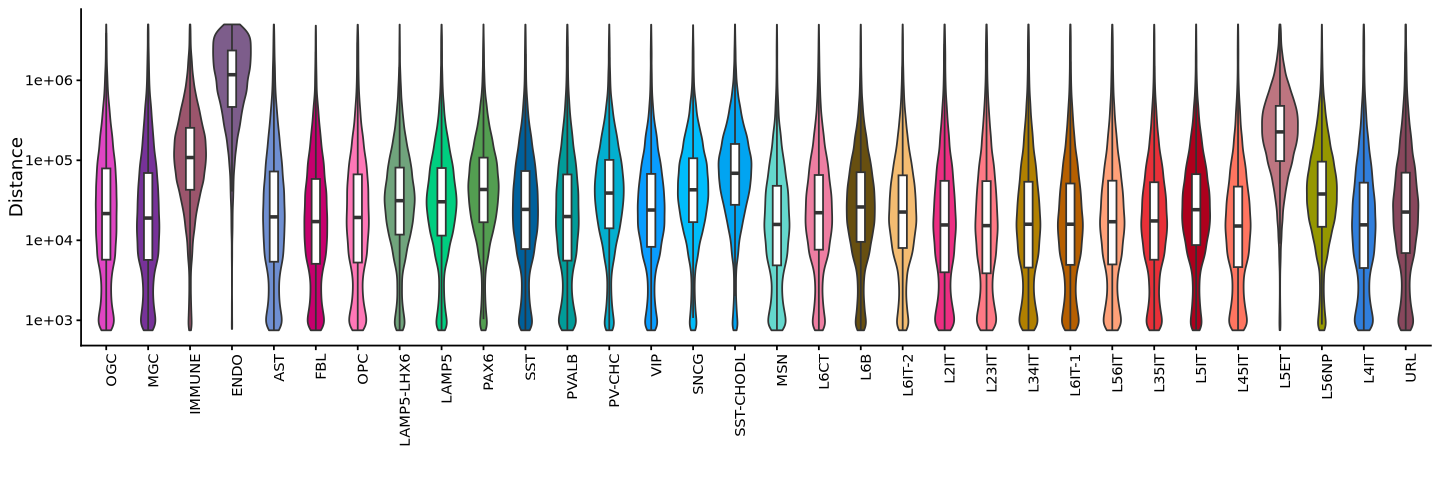

In [171]:
### Check E-P distance
t1 <- abci %>%
mutate(dist = abs(TargetGeneTSS - (start + end)/2)) %>%
mutate(CellType = factor(CellType, levels = corder)) %>%
ggplot(aes(x = CellType, y = dist)) + 
geom_violin(aes(fill = CellType)) + 
geom_boxplot(fill = "white", width = 0.2, outlier.shape = NA) + 
theme_classic() + scale_y_log10() +
xlab("") + ylab("Distance") + 
scale_fill_manual(values = ccol2) + NoLegend() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

options(repr.plot.width = 12, repr.plot.height = 4)
t1

In [179]:
### remove low confident cells from abc results
badcelltype <- c("ENDO", "IMMUNE", "L5ET", "SST-CHODL")
abcif <- abci %>% dplyr::filter(!(celltype %in% badcelltype))

abci %>% dplyr::select(name, TargetGene) %>% distinct %>% nrow
abcif %>% dplyr::select(name, TargetGene) %>% distinct %>% nrow

[1] 332713

[1] 264132

In [180]:
abci$range <- gsub(".*.\\|([^\\|]+)", "\\1", abci$name)
abcif$range <- gsub(".*.\\|([^\\|]+)", "\\1", abcif$name)

In [181]:
unique(abcif$range) %>% length
unique(abcif$TargetGene) %>% length

[1] 122409

[1] 19263

`summarise()` has grouped output by 'CellType'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'CellType'. You can override using the
`.groups` argument.


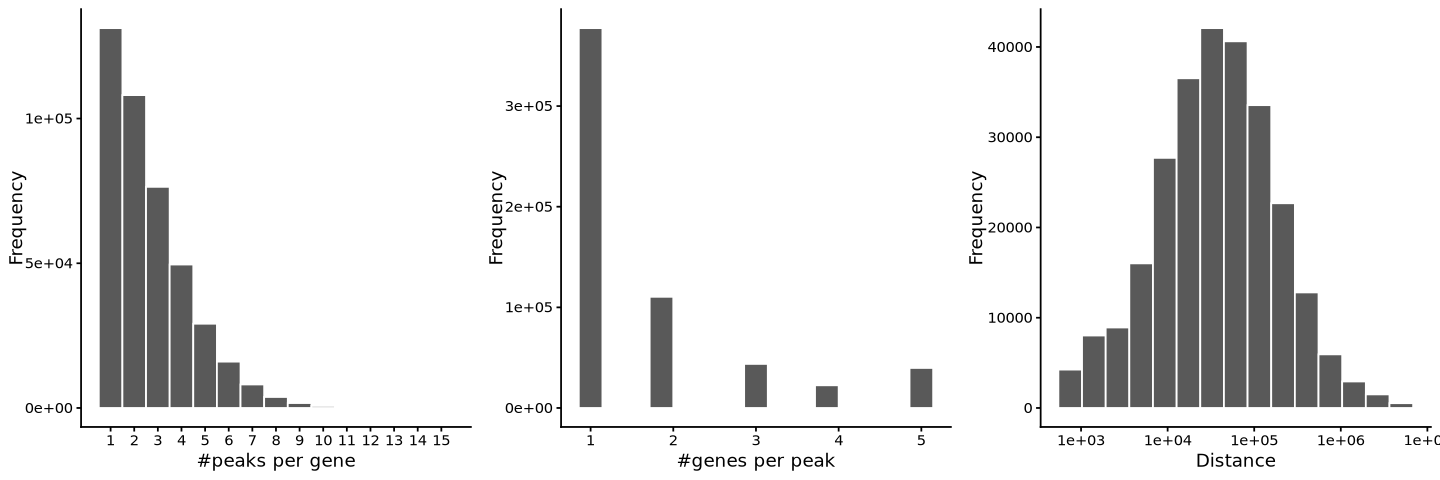

In [182]:
t1 <- abcif %>% 
dplyr::select(name, TargetGene, CellType) %>% distinct %>%
group_by(CellType, TargetGene) %>%
summarise(ngene = n_distinct(name)) %>%
ungroup %>% 
mutate(ngene = ifelse(ngene > 15, 15, ngene)) %>%
ggplot(aes(x = ngene)) +
geom_histogram(color = "white", bins = 15) + 
scale_x_continuous(breaks = seq(1, 15, 1)) + 
theme_classic() + 
xlab("#peaks per gene") + ylab("Frequency")

t2 <- abcif %>%
dplyr::select(name, TargetGene, CellType) %>% distinct %>%
group_by(CellType, name) %>%
summarise(ngene = n_distinct(TargetGene)) %>%
ungroup %>% 
mutate(ngene = ifelse(ngene > 5, 5, ngene)) %>%
ggplot(aes(x = ngene)) +
geom_histogram(color = "white", bins = 15) + 
scale_x_continuous(breaks = seq(1, 5, 1)) + 
theme_classic() + 
xlab("#genes per peak") + ylab("Frequency")

t3 <- abcif %>%
mutate(dist = abs(TargetGeneTSS - (start + end)/2)) %>%
dplyr::select(name, TargetGene, dist) %>% distinct %>%
ggplot(aes(x = dist)) + 
geom_histogram(color = "white", bins = 15) + 
theme_classic() + scale_x_log10() +
xlab("Distance") + ylab("Frequency")

fig1 <- cowplot::plot_grid(t1, t2, t3, ncol = 3)
options(repr.plot.width = 12, repr.plot.height = 4)
fig1

In [20]:
### bad cell types inflates distance due to power-law?
abci %>% 
dplyr::select(name, TargetGene, distance) %>% distinct %>%
dplyr::select(distance) %>% distinct %>%
summary

abcif %>%
dplyr::select(name, TargetGene, distance) %>% distinct %>%
dplyr::select(distance) %>% distinct %>%
summary

    distance      
 Min.   :    750  
 1st Qu.:  49182  
 Median : 124641  
 Mean   : 312337  
 3rd Qu.: 307631  
 Max.   :4999505  

    distance      
 Min.   :    750  
 1st Qu.:  35186  
 Median :  84814  
 Mean   : 208970  
 3rd Qu.: 197477  
 Max.   :4997488  

In [51]:
write.table(abci, "plot/broad_abc_conns.txt", sep = "\t", quote = F, row.names = T, col.names = T)
write.table(abcif, "plot/broad_abc_filtcelltype_conns.txt", sep = "\t", quote = F, row.names = T, col.names = T)

## Filter H3K27ac+ abc links

In [567]:
badcelltype <- c('IMMUNE' ,'ENDO', 'FBL', 'SST-CHODL', 'L5ET', 'MSN') ### from chromatin states!

clist <- list()
for (fname in pair_df$MiniAtlas){
    f <- paste0(fname, "_hba.whole.union.peaks.anno.bed")
    if (file.exists(paste0("../10.chromhmm/output/DNAme_hyperCGN//annotation/", f))){
        tmp <- read.table(paste0("../10.chromhmm/output/DNAme_hyperCGN//annotation/", f)) %>%
        filter(V5 %in% c("E8", "E7", "E6")) %>%
        mutate(range = paste0(V1, ":", V2, "-", V3))
        tlink <- abcif %>% filter(TargetGene %in% rownames(rmtx)) %>% filter(celltype == fname, range %in% tmp$range)
        clist[[fname]] <- tlink
    }
}

abcif3 <- do.call(rbind, clist) %>% filter(!(celltype %in% badcelltype))
length(unique(abcif3$celltype)) ### MSN are removed

[1] 26

In [726]:
### prepare for GRN
tmp <- abcif3[,c("TargetGene", "range", "distance", "ABC.Score")] %>% distinct %>%
group_by(TargetGene, range) %>% summarise(importance = sum(ABC.Score), distance = mean(distance)) %>% ungroup %>%
mutate(rho = 1, importance_x_rho = rho*importance, importance_x_abs_rho = abs(rho)*importance) %>%
dplyr::select(TargetGene, range, importance, rho, importance_x_rho, importance_x_abs_rho, distance) %>%
setNames(c('target', 'region', 'importance', 'rho', 'importance_x_rho', 'importance_x_abs_rho', 'Distance'))

write.table(tmp, "../11.GRN/H3K27ac_broad_abc_region_to_gene_adj.tsv", row.names = F, col.names = T, sep = '\t', quote = F)

`summarise()` has grouped output by 'TargetGene'. You can override using the `.groups` argument.


In [84]:
abcif3 %>% dplyr::select(range, TargetGene) %>% distinct %>% nrow
write.table(abcif3, "plot/broad_abc_filtcelltype_select_conns.txt", sep = "\t", quote = F, row.names = T, col.names = T)

[1] 200007

In [85]:
# abcif <- read.table("plot/broad_abc_filtcelltype_conns.txt", header = T)
abcif %>% dplyr::select(range, TargetGene) %>% distinct %>% nrow

[1] 264132

In [590]:
for (f in unique(abcif3$celltype)){
    tmp <- abcif3 %>% filter(celltype == f) %>% 
    filter(TargetGeneIsExpressed == 'True') %>% 
    mutate(gchr = chr, tss2 = TargetGeneTSS + 1) %>%
    dplyr::select(chr, start, end, gchr, TargetGeneTSS, tss2) %>% distinct
    write.table(tmp, paste0("/projects//ps-renlab2/y2xie/public_html/BICAN/MiniAtlas_subclass/broad_abc/", f, "_expression_filter.bedpe"), sep = "\t", quote = F, row.names = F, col.names = F)
}

In [8]:
for (f in unique(abcif3$celltype)){
    tmp <- abcif3 %>% filter(celltype == f) %>% 
    mutate(gchr = chr, tss2 = TargetGeneTSS + 1) %>%
    dplyr::select(chr, start, end, gchr, TargetGeneTSS, tss2) %>% distinct
    write.table(tmp, paste0("/projects//ps-renlab2/y2xie/public_html/BICAN/MiniAtlas_subclass/broad_abc/", f, "_filter.bedpe"), 
                sep = "\t", quote = F, row.names = F, col.names = F)
}

In [25]:
bs2025 <- read.csv("../../ref/Ben-Simon2025Cell_enhancer_list.xls", sep = "\t", header = T)
bs2025e <- bs2025 %>%
filter(X %in% c("On_Target_strong", "On_Target_weak", "On_Targt_weak", "Mixed_Target_strong", "Mixed_Target_weak")) %>%
filter(Species == "hg38", Type %in% c("Enhancer", "Bashed enhancer")) %>%
dplyr::select(Coordinates, Primary.TCP, Secondary.TCP.s, X) %>%
mutate(X = ifelse(X == "", "unknown", X))
bs2025e[,c("chrom", "start", "end")] <- stringr::str_split_fixed(bs2025e$Coordinates, pattern = "[:-]", n = 3)

In [67]:
nrow(bs2025e)
lrange1 <- GRanges(bs2025e[,"chrom"], ranges = IRanges(as.integer(bs2025e[,"start"]), as.integer(bs2025e[,"end"])))
lrange2 <- GRanges(abci[,"chr"], ranges = IRanges(as.integer(abci[,"start"]), as.integer(abci[,"end"])))
queryHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length

[1] 118

[1] 53

In [51]:
abctc <- abci[,c("chr","start","end","CellType")] %>% distinct %>%
mutate(matched1 = ifelse(CellType == "AST", "Astro", NA)) %>%
mutate(matched1 = ifelse(CellType == "ENDO", "Endo", matched1)) %>%
mutate(matched1 = ifelse(CellType == "L23IT", "L2-3_IT", matched1)) %>%
mutate(matched1 = ifelse(CellType == "L4IT", "L4_IT", matched1)) %>%
mutate(matched1 = ifelse(CellType == "L5ET", "L5_ET", matched1)) %>%
mutate(matched1 = ifelse(CellType == "L5IT", "L5_IT", matched1)) %>%
mutate(matched1 = ifelse(CellType == "L56NP", "L5-6_NP", matched1)) %>%
mutate(matched1 = ifelse(CellType == "L6IT", "L6_IT", matched1)) %>%
mutate(matched1 = ifelse(CellType == "LAMP5", "Lamp5", matched1)) %>%
mutate(matched1 = ifelse(CellType == "LAMP5-LHX6", "Lamp5_Lhx6", matched1)) %>%
mutate(matched1 = ifelse(CellType == "MGC", "Micro_PVM", matched1)) %>%
mutate(matched1 = ifelse(CellType == "OGC", "Oligo", matched1)) %>%
mutate(matched1 = ifelse(CellType == "PAX6", "Pax6", matched1)) %>%
mutate(matched1 = ifelse(CellType == "PVALB", "Pvalb", matched1)) %>%
mutate(matched1 = ifelse(CellType == "PV-CHC", "Pvalb_ChC", matched1)) %>%
mutate(matched1 = ifelse(CellType == "SNCG", "Sncg", matched1)) %>%
mutate(matched1 = ifelse(CellType == "SST", "Sst", matched1)) %>%
mutate(matched1 = ifelse(CellType == "SST-CHODL", "Sst_Chodl", matched1)) %>%
mutate(matched1 = ifelse(CellType == "VIP", "Vip", matched1)) %>%
mutate(matched1 = ifelse(CellType == "FBL", "VLMC", matched1)) %>%
mutate(matched2 = ifelse(CellType %in% unique(rmeta[rmeta$class == "GABA",]$subclass_corrected), "GABAergic", "others")) 

In [53]:
### Matched cell types
qlist <- list()
for (f in unique(abctc$matched1)){
    tmp1 <- abctc %>% filter(matched1 == f) %>% dplyr::select(chr, start, end)
    tmp3 <- abctc %>% filter(matched1 != f) %>% dplyr::select(chr, start, end) %>%
    slice_sample(n = nrow(tmp1))
    tmp2 <- bs2025e %>% filter(Primary.TCP == f) %>% dplyr::select(chrom, start, end)
    
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]), as.integer(tmp2[,3])))
    lrange3 <- GRanges(tmp3[,1], ranges = IRanges(as.integer(tmp3[,2]), as.integer(tmp3[,3])))
    
    bov <- subjectHits(findOverlaps(lrange3, lrange2)) %>% unique %>% length
    qov <- subjectHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length
    
    mtx <- matrix(c(qov, bov, nrow(tmp3) - qov, nrow(tmp3) - bov), nrow = 2)
    qtest <- fisher.test(mtx)
    qlist[[f]] <- data.frame(nEnhancer = nrow(tmp2), nOverlap = qov, nBackground = bov,
                             fisher_p = qtest$p.value, fisher_od = as.numeric(qtest$estimate), celltype = f)
}

qlist <- do.call(rbind, qlist)

In [ ]:
qlist$fisher_p

options(repr.plot.width = 10, repr.plot.height = 3)
qlist %>% dplyr::select(nEnhancer, nOverlap, nBackground, celltype) %>%
reshape2::melt() %>% 
ggplot(aes(x = celltype, y = value, fill = variable)) + 
geom_col(position = "dodge", color = "white") + 
theme_Publication()

In [54]:
### All celltypes comparsion
qlist <- list()
for (f in unique(bs2025e$Primary.TCP)){
    tmp1 <- abctc %>% filter(matched1 == f) %>% dplyr::select(chr, start, end) %>% distinct
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    slist <- list()
    for (k in unique(bs2025e$Primary.TCP)){
        tmp2 <- bs2025e %>% filter(Primary.TCP == k) %>% dplyr::select(chrom, start, end) %>% distinct
        lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]), as.integer(tmp2[,3])))
        qov <- subjectHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length
        sov <- queryHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length
        slist[[k]] <- data.frame(nref = nrow(tmp2), nqry = nrow(tmp1), 
                                 novlp_ref = qov, novlp_qry = sov, qcelltype = f, rcelltype = k)
    }
    qlist[[f]] <- do.call(rbind, slist)
}
qlist <- do.call(rbind, qlist)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr1, chr11, chr12, chr14, chr15, chr16, chr17, chr18, chr2, chr20, chr21, chr22, chr4, chr6, chr7, chr8, chr9
  - in 'y': chr19
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”
Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr1, chr11, chr12, chr14, chr15, chr16, chr17, chr18, chr2, chr20, chr21, chr22, chr4, chr6, chr7, chr8, chr9
  - in 'y': chr19
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”
Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr10, chr11, chr13, chr14, chr15, chr16, chr17, chr18, chr21, chr2

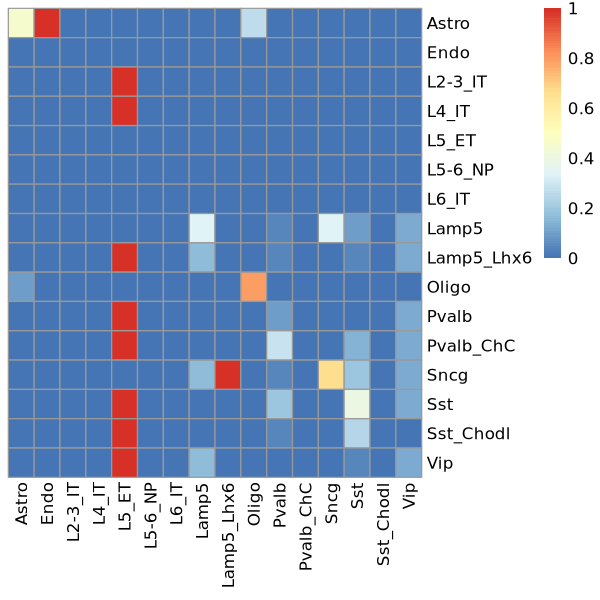

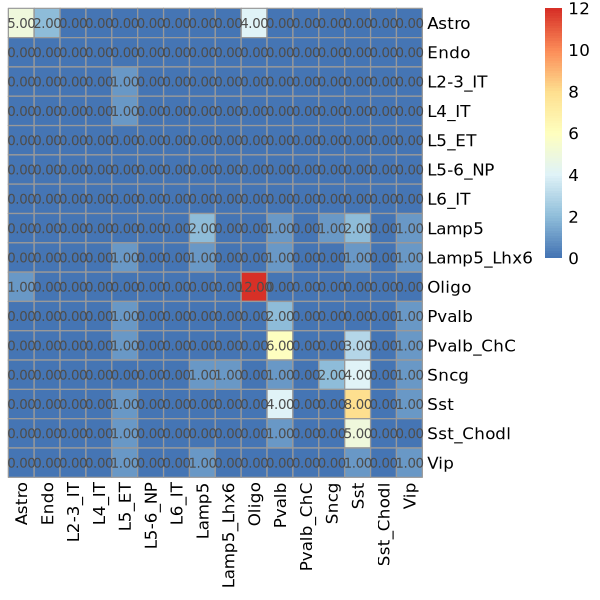

In [55]:
options(repr.plot.width = 5, repr.plot.height = 5)
qlist %>% 
mutate(ratio = novlp_ref/nref) %>%
reshape2::dcast(qcelltype ~ rcelltype, value.var = "ratio") %>%
tibble::column_to_rownames("qcelltype") %>%
pheatmap(cluster_rows = F, cluster_cols = F, angle_col = 90)

qlist %>% 
mutate(ratio = novlp_ref/nref) %>%
reshape2::dcast(qcelltype ~ rcelltype, value.var = "novlp_ref") %>%
tibble::column_to_rownames("qcelltype") %>%
pheatmap(cluster_rows = F, cluster_cols = F, angle_col = 90, display_number = T)

In [57]:
### Perturb seq results
ren2024 <- read.csv("../../ref/Ren2024biorxiv_crest_ace_enhancer.txt", sep = "\t", header = T)
tmp1 <- abci[,c("chr","start","end","CellType")] %>% 
filter(CellType %in% unique(rmeta[rmeta$class == "Glut",]$subclass_corrected)) %>%
dplyr::select(chr, start, end) %>% distinct
tmp3 <- abci[,c("chr","start","end","CellType")] %>%
filter(CellType %in% unique(rmeta[rmeta$class != "Glut",]$subclass_corrected)) %>%
dplyr::select(chr, start, end) %>% distinct %>%
slice_sample(n = nrow(tmp1))

lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
lrange2 <- GRanges(ren2024[,1], ranges = IRanges(as.integer(ren2024[,2]), as.integer(ren2024[,3])))
lrange3 <- GRanges(tmp3[,1], ranges = IRanges(as.integer(tmp3[,2]), as.integer(tmp3[,3])))

bov <- subjectHits(findOverlaps(lrange3, lrange2)) %>% unique %>% length
qov <- subjectHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length

mtx <- matrix(c(qov, bov, nrow(ren2024) - qov, nrow(ren2024) - bov), nrow = 2)
mtx

fisher.test(mtx) ### fewer than background??

9,51
11,49



	Fisher's Exact Test for Count Data

data:  mtx
p-value = 0.8071
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.263271 2.298881
sample estimates:
odds ratio 
 0.7876767 


In [62]:
### zemke nature 2023
zemke2023 <- data.table::fread("../../ref/Zemke2023Nature/Supplementary_Table_27.tsv") %>% as.data.frame
zemke2023c <- data.table::fread("../../ref/Zemke2023Nature/Supplementary_Table_4.tsv") %>% as.data.frame
zemke2023 <- merge(zemke2023, zemke2023c[,1:2], by.x = "human_union_peak_id", by.y = "peak_id") %>% reshape2::melt() %>% filter(!is.na(value))
zemke2023$variable <- as.character(zemke2023$variable)
zemke2023 <- zemke2023 %>% 
mutate(variable = ifelse(variable == "ChC", "PV-CHC", variable)) %>%
mutate(variable = ifelse(variable == "L2_3_IT", "L23IT", variable)) %>%
mutate(variable = ifelse(variable == "L4_5_IT", "L45IT", variable)) %>%
mutate(variable = ifelse(variable == "L5_IT", "L5IT", variable)) %>%
mutate(variable = ifelse(variable == "L6_IT", "L6IT-1", variable)) %>%
mutate(variable = ifelse(variable == "L6_IT_CAR3", "L6IT-2", variable)) %>%
mutate(variable = ifelse(variable == "L5_ET", "L5ET", variable)) %>%
mutate(variable = ifelse(variable == "L5_6_NP", "L56NP", variable)) %>%
mutate(variable = ifelse(variable == "L6_CT", "L6CT", variable)) %>%
mutate(variable = ifelse(variable == "L6b", "L6B", variable)) %>%
mutate(variable = ifelse(variable == "Endo", "ENDO", variable)) %>%
mutate(variable = ifelse(variable == "VLMC", "FBL", variable)) %>%
mutate(variable = ifelse(variable == "ODC", "OGC", variable)) %>%
mutate(variable = ifelse(variable == "ASC", "AST", variable))
zemke2023[,c("chrom", "start", "end")] <- stringr::str_split_fixed(zemke2023$hg38_coord, pattern = "-", n = 3)

Using human_union_peak_id, putative_target_gene, hg38_coord as id variables



In [611]:
### All celltypes comparsion
qlist <- list()
for (f in unique(zemke2023$variable)){
    tmp1 <- abci %>% filter(CellType == f) %>% dplyr::select(chr, start.x, end.x) %>% distinct
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    slist <- list()
    for (k in unique(zemke2023$variable)){
        tmp2 <- zemke2023 %>% filter(variable == k) %>% dplyr::select(chrom, start, end) %>% distinct
        lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]), as.integer(tmp2[,3])))
        qov <- subjectHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length
        sov <- queryHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length
        slist[[k]] <- data.frame(nref = nrow(tmp2), nqry = nrow(tmp1), 
                                 novlp_ref = qov, novlp_qry = sov, qcelltype = f, rcelltype = k)
    }
    qlist[[f]] <- do.call(rbind, slist)
}
qlist <- do.call(rbind, qlist)

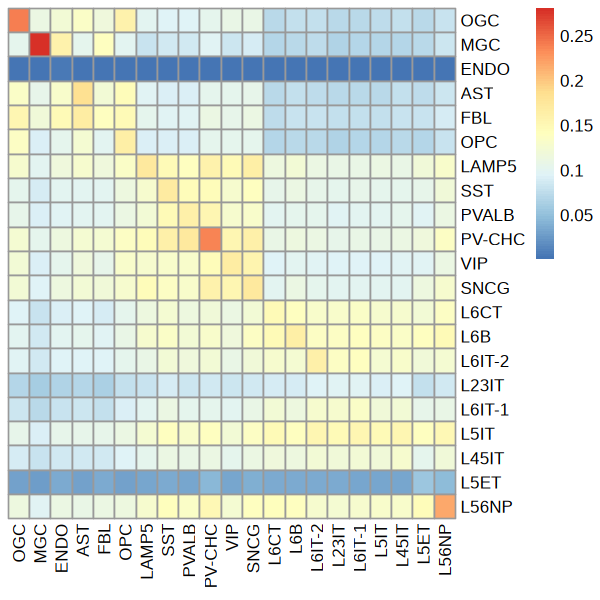

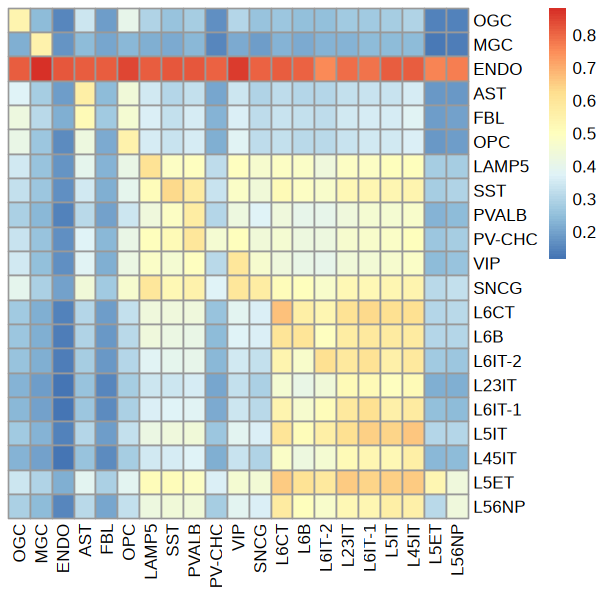

In [612]:
options(repr.plot.width = 5, repr.plot.height = 5)
qlist %>% mutate(ratio = novlp_ref/nref) %>%
mutate(qcelltype = factor(qcelltype, levels = corder)) %>%
mutate(rcelltype = factor(rcelltype, levels = corder)) %>%
reshape2::dcast(qcelltype ~ rcelltype, value.var = "ratio") %>%
tibble::column_to_rownames("qcelltype") %>%
pheatmap(cluster_rows = F, cluster_cols = F, angle_col = 90)

qlist %>% mutate(ratio = novlp_qry/nqry) %>%
mutate(qcelltype = factor(qcelltype, levels = corder)) %>%
mutate(rcelltype = factor(rcelltype, levels = corder)) %>%
reshape2::dcast(qcelltype ~ rcelltype, value.var = "ratio") %>%
tibble::column_to_rownames("qcelltype") %>%
pheatmap(cluster_rows = F, cluster_cols = F, angle_col = 90)

In [59]:
### vista
vista <- read.table("/projects//ps-renlab2/y2xie/projects/genome_ref/vista_enhancer_2024_locus.tsv", header = T)
gccod <- vista %>% filter(curation_status == "positive" & assembly == "hg38") %>% 
dplyr::select(coordinate_hg38) %>% unique %>% unlist
gccod <- stringr::str_split_fixed(gccod, pattern = "[:-]", n = 3) %>% as.data.frame
gccod <- gccod[grep("chr", gccod$V1),]
gcrange <- GRanges(gccod[,1], ranges = IRanges(as.numeric(gccod[,2]), as.numeric(gccod[,3])))

In [65]:
p1 <- read.table("../07.cCREs/cCREs_w_H3K27ac/w_ac.ccre.all")
p2 <- read.table("../07.cCREs/cCREs_w_H3K27ac/wo_ac.ccre.all")
p3 <- abci[,1:3] %>% distinct
p4 <- distinct(conns[,c("chr1", "start1", "end1")]) %>% setNames(c("V1", "V2", "V3")) %>% as.data.frame
p5 <- zemke2023[,c('chrom','start','end')] %>% distinct

### generate random bed by shuffle
# write.table(rbind(p1, p2), "tmp.bed", sep = "\t", row.names = F, col.names = F, quote = F)
# system("bedtools shuffle -i tmp.bed -g /projects/ps-renlab2/y2xie/projects/genome_ref/hg38.main.chrom.sizes -excl /projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/hg38-blacklist.v2.bed -noOverlapping -seed 921 > tmp_shuffle.bed")
sfbed <- read.table("tmp_shuffle.bed")
sfrange <- GRanges(sfbed[,1], ranges = IRanges(as.numeric(sfbed[,2]), as.numeric(sfbed[,3])))
w0 <- queryHits(findOverlaps(sfrange, gcrange)) %>% unique %>% length

### contingency table
### compare to random
cting <- list()
i = 1
for (f in list(p1, p2, p3, p4, p5)){
    qrange <- GRanges(f[,1], ranges = IRanges(as.numeric(f[,2]), as.numeric(f[,3])))
    w1 <- queryHits(findOverlaps(qrange, gcrange)) %>% unique %>% length
    cting[[i]] <- c(w1, nrow(f) - w1)
    i = i + 1
}
cting[[i]] <- c(w0, nrow(sfbed)-w0)
cting <- do.call(rbind, cting)

cdf <- list()
for (i in 1:(nrow(cting)-1)){
    cdf[[i]] <- data.frame(pvalue = fisher.test(cting[c(i,nrow(cting)),])$p.value, 
                           or = fisher.test(cting[c(i,nrow(cting)),])$estimate) 
}
cdf <- do.call(rbind, cdf)
cdf$group <- c("w_ac", "wo_ac", "abc", "atac_conns", "zemke2023")

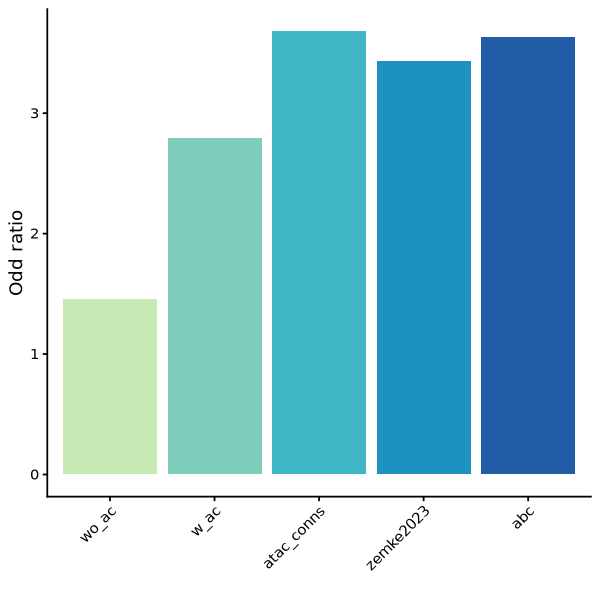

In [66]:
options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- cdf %>%
mutate(group = factor(group, levels = c("wo_ac", "w_ac", "atac_conns", "zemke2023", "abc"))) %>%
ggplot(aes(x = group, y = or, fill = group)) + 
geom_col() + ylab("Odd ratio") + xlab("") + 
theme_classic() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_fill_manual(values = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(8)[3:8]) + 
NoLegend()
     
t1

In [64]:
### PsyENCODE EP links
wang2018 <- read.table("/projects/ps-renlab2/y2xie/projects/BICAN/ref/Wang2018Science_PsyENCODE/INT-16_HiC_EP_linkages_hg38Gene_hg38Enh.bed")
wang2018[,c("chr", "start", "end")] <- stringr::str_split_fixed(wang2018$V5, pattern = "[:-]", n = 3)
wang2018 <- wang2018[wang2018$chr != "NA", ]

head(wang2018)
dim(wang2018)

,V1,V2,V3,V4,V5,chr,start,end
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,10419943,10419944,ENSG00000251503,chr1:9949776-9950326,chr1,9949776,9950326
2,chr1,10419943,10419944,ENSG00000175279,chr1:9949776-9950326,chr1,9949776,9950326
3,chr1,10229942,10229943,ENSG00000054523,chr1:9949776-9950326,chr1,9949776,9950326
4,chr1,10419943,10419944,ENSG00000251503,chr1:9950347-9950895,chr1,9950347,9950895
5,chr1,10229942,10229943,ENSG00000054523,chr1:9950347-9950895,chr1,9950347,9950895
6,chr1,10419943,10419944,ENSG00000175279,chr1:9950347-9950895,chr1,9950347,9950895


[1] 89866     8

In [68]:
tmp <- abcif %>% mutate(TargetGeneTSS2 = TargetGeneTSS + 1) %>%
dplyr::select(chr,start,end,TargetGeneTSS,TargetGeneTSS2) %>% 
setNames(c('chrom.x','start.x','end.x','start.y','end.y')) %>% distinct
lrange1 <- GRanges(tmp$chrom.x, ranges = IRanges(as.integer(tmp$start.x), as.integer(tmp$end.x)))
lrange2 <- GRanges(tmp$chrom.x, ranges = IRanges(as.integer(tmp$start.y)-250, as.integer(tmp$end.y)+250))
gi <- GInteractions(lrange1, lrange2)

lrange1 <- GRanges(wang2018$chr, ranges = IRanges(as.integer(wang2018$start), as.integer(wang2018$end)))
lrange2 <- GRanges(wang2018$V1, ranges = IRanges(as.integer(wang2018$V2)-250, as.integer(wang2018$V2)+250))
gi2 <- GInteractions(lrange1, lrange2)

In [69]:
sov <- subjectHits(findOverlaps(gi, gi2, type = "any", use.region="both")) %>% unique
qov <- queryHits(findOverlaps(gi, gi2, type = "any", use.region="both")) %>% unique ### 0.2% of loops??? this is too few
length(sov)
length(qov)

[1] 393

[1] 199

In [72]:
abcif %>% dim
abcif[,c('chr','start','end', 'TargetGeneTSS')] %>% distinct %>% dim

[1] 1184471      33

[1] 273546      4

## Visualize representative E-P interactions

In [98]:
### Only plot genes with the highest abc score
### arrange using NMF
dir <- "abc_select"
t1 <- read.table(paste0("abc_nmf/", dir, "/res/peaks.entropy.sta.txt")) %>%
tibble::column_to_rownames("V1") %>% t %>% as.data.frame %>%
arrange(Median, Mean) %>% head(3)

t2 <- read.table(paste0("abc_nmf/", dir, "/res/peaks.sparseness.sta.txt")) %>%
tibble::column_to_rownames("V1") %>% t %>% as.data.frame %>%
arrange(desc(Median), desc(Mean)) %>% head(3)

intersect(t1$rank, t2$rank)

[1] 28 25

[1] 28

[1] 28

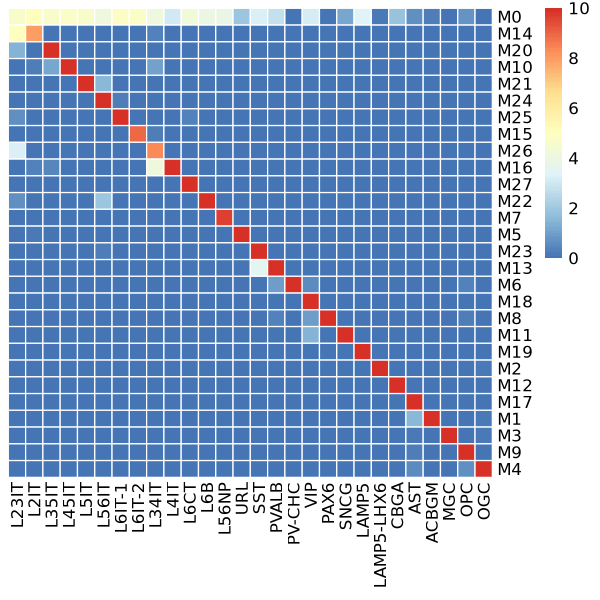

In [120]:
bestres <- max(intersect(t1$rank, t2$rank))
nmf <- read.table(paste0("abc_nmf/", dir, "/res/peaks.r", bestres, "n10.statW"))
mx <- read.table(paste0("abc_nmf/", dir, "/res/peaks.r", bestres, "n10.H.mx"), sep = "\t")
unique(nmf$V3) %>% length
nrow(mx)

rownames(mx) <- paste0("M", 0:max(unique(nmf$V3)))
colnames(mx) <- read.table(paste0("abc_nmf/", dir, "/peaks.ygi")) %>% dplyr::select(V1) %>% unlist %>% as.character

max_indices <- max.col(mx)
permutation_vector <- order(max_indices)
olist <- mx[permutation_vector, ]

options(repr.plot.width = 5, repr.plot.height = 5)
olist %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90,
         border_color = "white", show_rownames = T, breaks = seq(0, 10, 0.1)) 

In [100]:
clevel <- c("M0", setdiff(rownames(olist), "M0"))
clevel <- gsub("M", "", clevel)
table(nmf$V3)#[clevel]


    0     1     2     3     4     5     6     7     8     9    10    11    12 
18631  5685  5765 10073  5817  3784   959 11840   454  2297  2458  1060  1057 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
  763 16574 10277   464  6326  1426  3113  3105  4475   350   327   940   170 
   26    27 
 2096  2123 

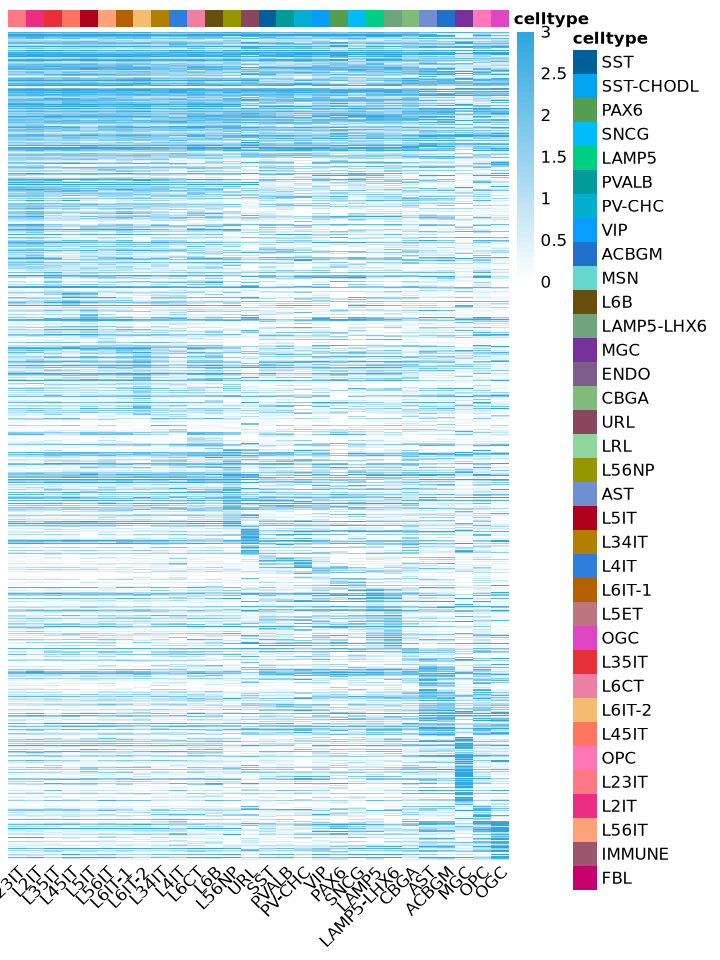

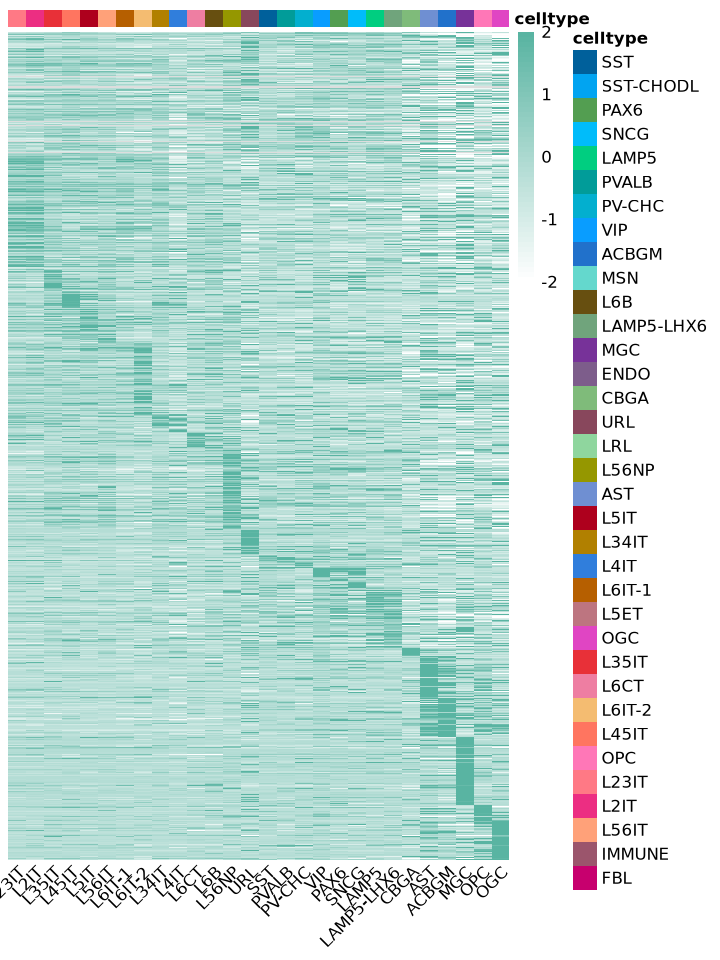

In [154]:
### for pair
eorder <- distinct(nmf[, c("V1", "V3")]) %>% 
mutate(V3 = factor(V3, levels = clevel)) %>%
arrange(V3) %>% dplyr::select(V1) %>% unlist %>% as.character # %>% unique

elist <- stringr::str_split_fixed(eorder, pattern = "_", n = 2) %>% as.data.frame

canno2 <- data.frame(label = colnames(mx), celltype = colnames(mx)) %>% tibble::column_to_rownames("label")
rannocolor <- list(celltype = ccol2)

options(repr.plot.width = 6, repr.plot.height = 8)

tmtx1 <- as.matrix(qmtx)[elist[[1]], colnames(mx)]
rownames(tmtx1) <- eorder
t1 <- tmtx1 %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 45,
         annotation_col = canno2, annotation_colors = rannocolor,
         border_color = NA, show_rownames = F, breaks = seq(0, 3, 0.06), 
         color = colorRampPalette(c("white", "#2EA7E0"))(50)) 

tmtx2 <- as.matrix(rmtx)[elist[[2]], colnames(mx)]
rownames(tmtx2) <- eorder
t2 <- tmtx2 %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", angle_col = 45, 
         annotation_col = canno2, annotation_colors = rannocolor,
         border_color = NA, show_rownames = F, breaks = seq(-2, 2, 0.08), 
         color = colorRampPalette(c("white", "#59b4a2"))(50)) 

In [233]:
write.table(tmtx1, paste0("plot/H3K27ac_abc_filtcelltype_", dir, "_nmf_H3K27ac.xls"), sep = "\t", row.names = T, col.names = T)
write.table(tmtx2, paste0("plot/H3K27ac_abc_filtcelltype_", dir, "_nmf_gex.xls"), sep = "\t", row.names = T, col.names = T)

In [ ]:
flist <- flist2 <- list()
for (f in unique(nmf$V3)){ 
    qgene <- nmf[nmf$V3 == f,] %>% dplyr::select(V1) %>% unlist %>% as.character
    qgene <- stringr::str_split_fixed(qgene, pattern = "_", n = 2)[,2] %>% unique
    print(length(qgene))
    qtable <- enrichGO(gene = qgene,
                OrgDb = org.Hs.eg.db,
                keyType = 'SYMBOL',
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)
    flist[[paste0("M", f)]] <- qtable@result %>% mutate(celltype = f) 
    qtable2 <- clusterProfiler::simplify(qtable, cutoff=0.7, by="p.adjust", select_fun=min)
    flist2[[paste0("M", f)]] <- qtable2@result %>% mutate(celltype = f) # %>% filter(p.adjust < 0.05)
}

do.call(rbind, flist2) %>%
dplyr::select(celltype) %>% table

write.table(do.call(rbind, flist), paste0("abc_go/H3K27ac_abc_filtcelltype_", dir, "_", bestres, "_enrichGO.xls"), sep = "\t", quote = F, row.names = F, col.names=  T)
write.table(do.call(rbind, flist2), paste0("abc_go/H3K27ac_abc_filtcelltype_", dir, "_", bestres, "_enrichGO_simplify.xls"), sep = "\t", quote = F, row.names = F, col.names=  T)

In [107]:
flist2 %>%
filter(celltype %in% c(0, 14, 10, 21, ))
dplyr::select(celltype) %>% table

celltype
  0   1   2   3   4   6   7   9  10  14  15  16  17  18  21  22  27 
213 147   6 315  11   2   2  29   1  61   6   8 209  15   1   2   4 

In [756]:
do.call(rbind, flist2) %>%
dplyr::select(celltype) %>% table


celltype
  0   1   2   3   4   6   7   9  10  14  15  16  17  18  21  22  27 
213 147   6 315  11   2   2  29   1  61   6   8 209  15   1   2   4 

In [751]:
qterm1 <- read.csv(paste0("abc_go/H3K27ac_abc_filtcelltype_", dir, "_", bestres, "_enrichGO_simplify.xls"), sep = "\t") %>%
group_by(celltype) %>% filter(p.adjust < 0.05, Count >= 2) %>%
slice_max(order_by = -log10(p.adjust), n = 2) %>%
ungroup %>% dplyr::select(Description) %>% unlist %>% unique

tmp <- read.csv(paste0("abc_go/H3K27ac_abc_filtcelltype_", dir, "_", bestres, "_enrichGO.xls"), sep = "\t") %>%
reshape2::dcast(Description ~ celltype, value.var = "p.adjust", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1

ttp1 <- -log2(tmp[qterm1, clevel])
ttp1[ttp1 > 50] <- 50

lmat1 <- tmp
lmat1 <- ifelse(lmat1 < 0.05, "*", "")

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 6)
ttp1[, clevel] %>% 
pheatmap(cluster_cols = F, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = lmat1[rownames(ttp1), clevel], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(25))

In [111]:
mclass <- read.table("/projects//ps-renlab2/y2xie/projects/genome_ref/241102_JASPAR2022/240722_WE_JASPAR_2022_monaLisa_Dump_noPseudo_thresh0.7_annotated.txt", header = T)

motif <- list()
for (f in list.files("abc_motif/", pattern = "abc_wubin_select_nmf_M.*.bed")){
    fname <- gsub("abc_wubin_select_nmf_([^.]+).bed", "\\1", f)
    tmp <- read.csv(paste0("abc_motif/abc_wubin_select_nmf_", fname, "/knownResults.txt"), sep = "\t", row.names = 1) %>%
    setNames(c("consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
    tibble::rownames_to_column("motif") %>% mutate(celltype = paste0(fname))
    tmp$mclass <- mclass[match(tmp$motif, mclass$JASPER),]$Cluster_name
    
    motif[[f]] <- tmp
}

### Plot strongest motifs first
lmotif1 <- do.call(rbind, motif) %>%
filter(fdr < 0.01) %>%
group_by(celltype, mclass) %>% 
slice_max(order_by = -log_p_value, n = 1) %>%
slice_sample(n = 1) %>%
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
lmotif1 <- lmotif1[!is.na(lmotif1)]

rmat1 <- do.call(rbind, motif) %>%
reshape2::dcast(celltype ~ motif, value.var = "fdr", fun.aggregate = min) %>%
tibble::column_to_rownames("celltype")
rmat1[is.na(rmat1)] <- 1
rmat1 <- -log10(rmat1)
rmat1[rmat1 > 6] <- 6

smat1 <- rmat1[intersect(paste0("M", clevel), rownames(rmat1)), lmotif1] %>% t
max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]

### Label the strongest in each module
lmotif2 <- do.call(rbind, motif) %>%
filter(motif %in% lmotif1) %>%
group_by(celltype) %>% 
slice_max(order_by = -log_p_value, n = 2) %>%
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
llabel <- rownames(smat1)
llabel[!(llabel %in% lmotif2)] <- ""

Warning message in .fun(.value[0], ...):
“no non-missing arguments to min; returning Inf”


In [115]:
clevel

[1] "0"  "14" "20" "10" "21" "24" "25" "15" "26" "16" "27" "22" "7"  "5"  "23"
[16] "13" "6"  "18" "8"  "11" "19" "2"  "12" "17" "1"  "3"  "9"  "4"

In [119]:
do.call(rbind, motif) %>%
filter(fdr < 0.01) %>%
group_by(celltype) %>% 
slice_max(-log_p_value, n = 3) %>% ungroup %>%
mutate(celltype = factor(celltype, levels = paste0("M", clevel))) %>%
arrange(celltype)

motif,consensus,p_value,log_p_value,fdr,tgt_num,tgt_pct,bgd_num,bgd_pct,celltype,mclass
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<fct>,<chr>
MA0139.1_CTCF,TGGCCACYAGGGGGCRCYA,1e-58,-133.80,0.0000,3772,20.25%,76626.1,15.78%,M0,CTCF_cluster
MA1930.1_CTCF,CTGCAGTKCCNVCHNHYGGCCACYAGRKGGCRCYN,1e-26,-60.27,0.0000,2200,11.81%,45828.7,9.44%,M0,CTCF_cluster
MA1125.1_ZNF384,WNWAAAAAAAAA,1e-17,-39.54,0.0000,5241,28.13%,123191.7,25.37%,M0,ZNF384_cluster
MA0510.2_RFX5,SGTTGCCATGGCAACS,1e-50,-115.30,0.0000,688,4.15%,11618.7,2.23%,M14,RFX1_cluster
MA0600.2_RFX2,SGTTGCCATGGCAACS,1e-44,-103.50,0.0000,606,3.66%,10162.0,1.95%,M14,RFX1_cluster
MA0509.3_RFX1,SGTTGCCATGGCAACS,1e-35,-81.31,0.0000,374,2.26%,5726.5,1.10%,M14,RFX1_cluster
MA1151.1_RORC,NWAWNTAGGTCA,1e-11,-27.56,0.0000,484,19.69%,77318.9,14.47%,M10,RORA_cluster
MA1642.1_NEUROG2,NNRACAGATGGNN,1e-13,-30.13,0.0000,1408,31.46%,141693.7,26.50%,M21,NEUROG2_cluster
MA1109.1_NEUROD1,NRACAGATGGYNN,1e-11,-27.10,0.0000,1268,28.34%,127287.8,23.81%,M21,NEUROG2_cluster


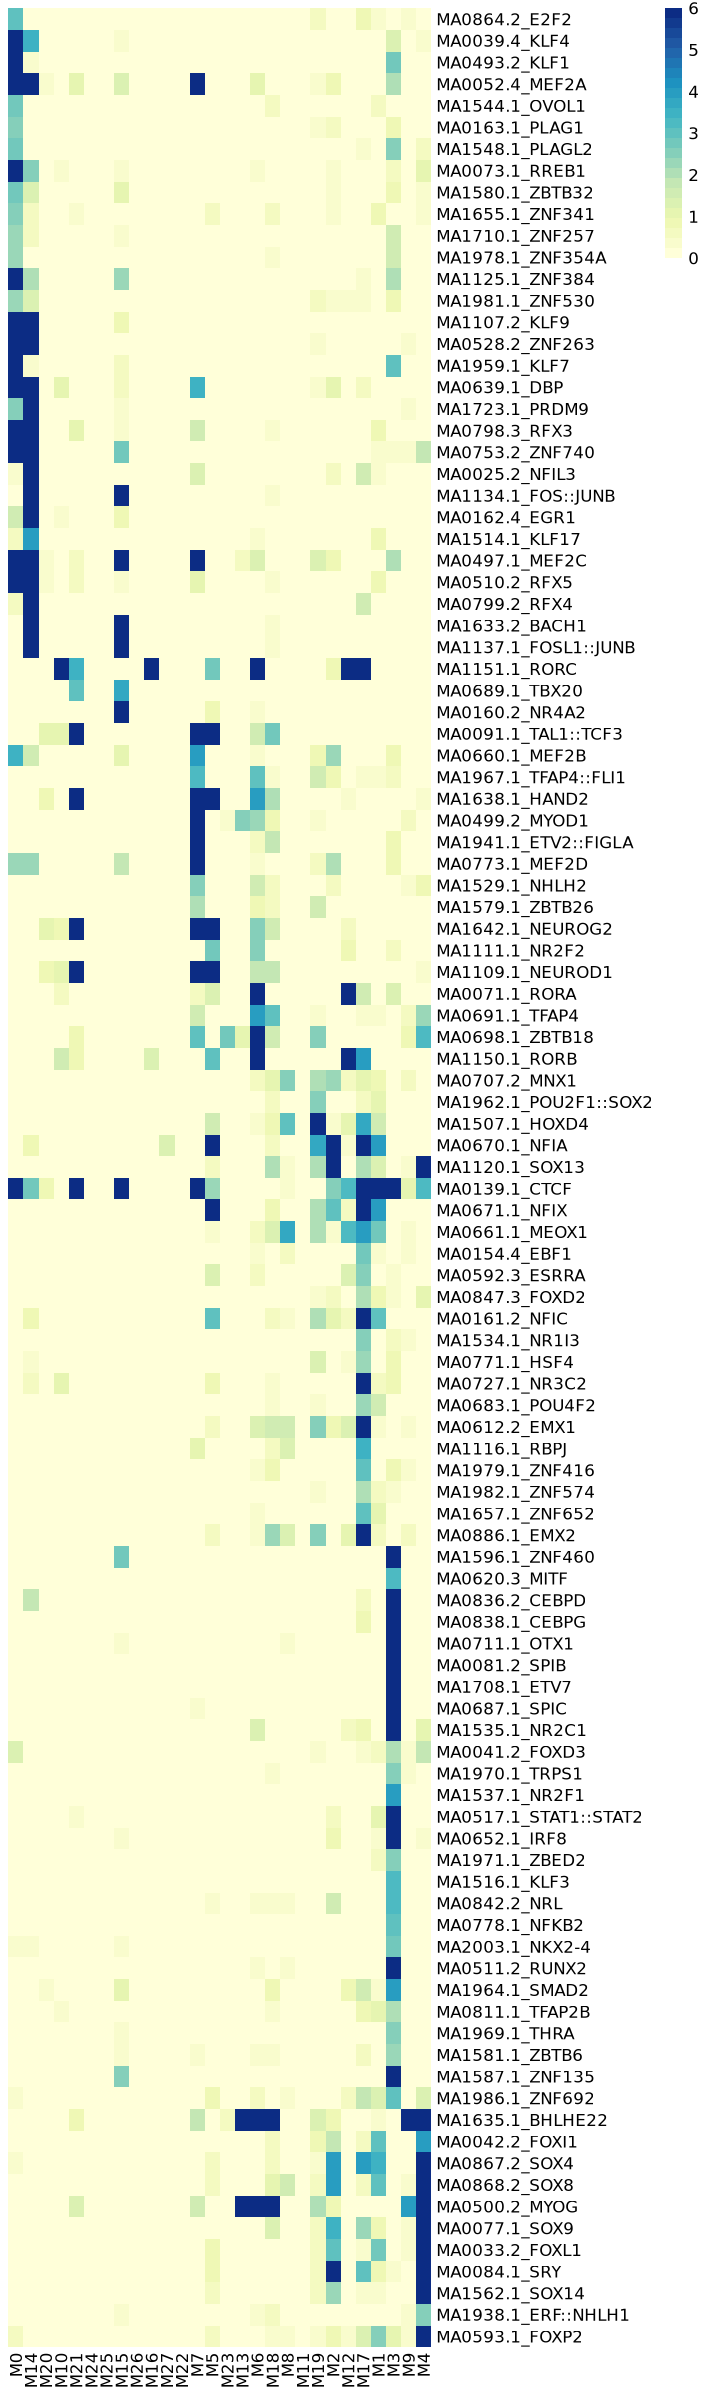

In [32]:
options(repr.plot.width = 6, repr.plot.height = 20)
fig1 <- smat1 %>% 
pheatmap(cluster_cols = F, cluster_rows = F, # gaps_row = nrow(smat2), 
         # labels_row = llabel, 
         show_rownames = T,
         border_color = NA, show_colnames = T, 
         angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

In [754]:
degene <- read.csv("../04.clustering/02.RNA/edgeR_250808/subclass_corrected_edgeR.dds")
d1 <- degene %>% filter(FDR < 0.05, logFC >= 1) %>% dplyr::select(gene) %>% unlist %>% unique

intersect(d1, ugene) %>% length # 2801/(4599+118)
intersect(d1, sgene) %>% length # 9577/(7418+4599)

2801/(4599+118)
9577/(7418+4599)

[1] 2801

[1] 9577

[1] 0.5938096

[1] 0.7969543

In [759]:
fisher.test(matrix(c(2801, 9577, (4599+118)-2801, (7418+4599)-9577), nrow = 2))


	Fisher's Exact Test for Count Data

data:  matrix(c(2801, 9577, (4599 + 118) - 2801, (7418 + 4599) - 9577), nrow = 2)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3459422 0.4010211
sample estimates:
odds ratio 
 0.3724839 


In [755]:
### How many are DA
darange <- read.csv("../../ref/hba_ATAC/snATAC_matched_MiniAtlas_cCRE.diff.LRtest.csv", header = T) %>%
setNames(c("id", "range", "logFC", "pvalue", "fdr", "celltype"))
d1 <- darange %>% filter(fdr < 0.05, logFC >= 1, celltype %in% pair_df[,2]) %>% 
dplyr::select(range) %>% unlist %>% unique

intersect(d1, urange) %>% length # 5696/(5814+4259)
intersect(d1, srange) %>% length # 60713/(5814+69347)

5696/(5814+4259)
60713/(5814+69347)

[1] 5696

[1] 60713

[1] 0.5654721

[1] 0.8077726

In [758]:
fisher.test(matrix(c(5696, 60713, (5814+4259)-5696, (5814+69347)-60713), nrow = 2))


	Fisher's Exact Test for Count Data

data:  matrix(c(5696, 60713, (5814 + 4259) - 5696, (5814 + 69347) - 60713), nrow = 2)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2964923 0.3235027
sample estimates:
odds ratio 
 0.3096898 


Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


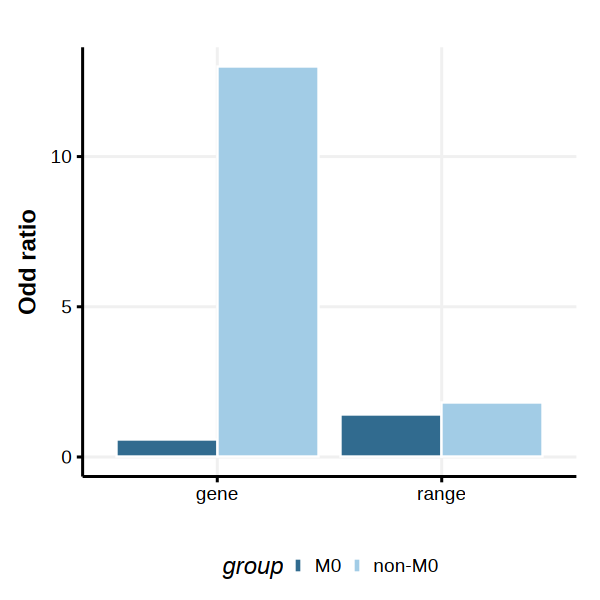

In [611]:
options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- rbind(df1, df2) %>%
mutate(group = ifelse(group %in% c("urange", "ugene"), "M0", group)) %>%
mutate(group = ifelse(group %in% c("srange", "sgene"), "non-M0", group)) %>%
ggplot(aes(x = class, y = OR, fill = group)) + 
geom_col(position = "dodge", color = "white") + 
theme_Publication() + 
xlab("") + ylab("Odd ratio") + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 


t1
### genes in M0 is more invariable (so does their enhancers!!)

In [138]:
### Find example
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,14440573,771.3,40986044,2188.9,40986044,2188.9
Vcells,140673978,1073.3,238729515,1821.4,238722507,1821.4


In [140]:
d1 <- degene %>% filter(FDR < 0.05, logFC >= 1) %>% dplyr::select(gene) %>% unlist %>% unique
d2 <- darange %>% filter(fdr < 0.05, logFC >= 1, celltype %in% pair_df[,2]) %>% dplyr::select(range) %>% unlist %>% unique

qpair <- abcif %>% 
filter(TargetGene %in% d1) %>%
filter(range %in% d2) %>%
filter(abs(((start.x + end.x)/2) - start.y) >= 100000) %>%
mutate(pair = paste0(range, ":", TargetGene)) %>%
dplyr::count(pair, name = "pair_count") %>%
filter(pair_count <= 2) %>%
dplyr::select(pair) %>% unlist %>% as.character

abcif %>% 
filter(paste0(range, ":", TargetGene) %in% qpair) %>%
dim

[1] 30804    15

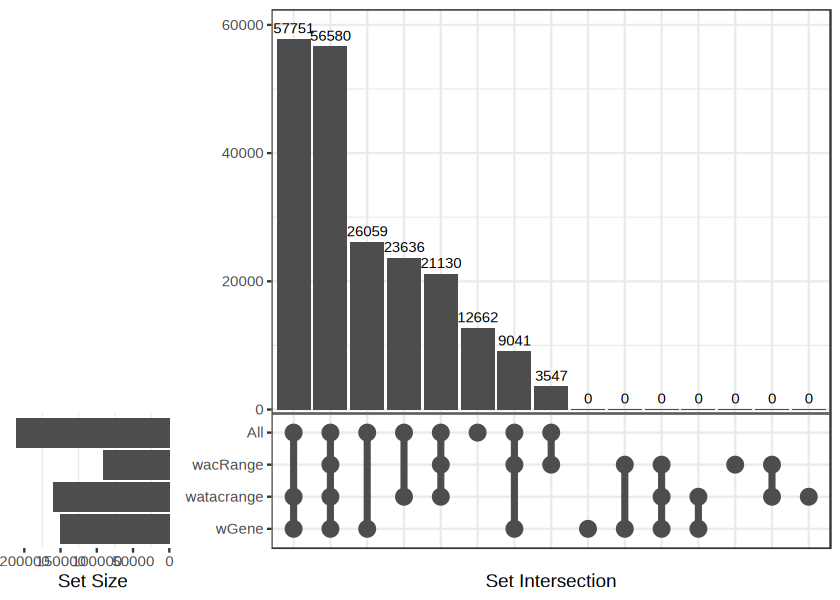

In [201]:
library(ggVennDiagram)

tmp1 <- degene %>% filter(FDR < 0.05, logFC >= 1, celltype %in% unique(abcif$celltype)) %>% dplyr::select(gene) %>% unlist %>% unique
tmp2 <- dacrange %>% filter(fdr < 0.05, logFC >= 1, celltype %in% unique(abcif$celltype)) %>% 
dplyr::select(range) %>% unlist %>% unique
tmp3 <- darange %>% filter(fdr < 0.05, logFC >= 1, celltype %in% pair_df[pair_df$MiniAtlas %in% unique(abcif$celltype),2]) %>% 
dplyr::select(range) %>% unlist %>% unique

### ac+ only?
d1 <- abcif2[,c("TargetGene", "range")] %>% distinct %>% mutate(pair = paste0(TargetGene, "_", range))
d2 <- d1 %>% filter(TargetGene %in% tmp1)
d3 <- d1 %>% filter(range %in% tmp2)
d4 <- d1 %>% filter(range %in% tmp3)

qlist <- list(d1$pair, d2$pair, d3$pair, d4$pair)
names(qlist) <- c("All", "wGene", "wacRange", "watacrange")

t1 <- ggVennDiagram(qlist, force_upset = TRUE, order.set.by = "name")

options(repr.plot.width = 7, repr.plot.height = 5)
t1

In [202]:
ggsave(t1, filename = paste0("plot/H3K27ac_wubin_abc_ovlp_DEgenes_DApeaks_upset.pdf"), 
       dpi = 300, height = 5, width = 7)

In [804]:
qterm1 <- read.csv(paste0("abc_go/", dir, "_", bestres, "_enrichGO_simplify.xls"), sep = "\t") %>%
group_by(celltype) %>% filter(p.adjust < 0.05, Count >= 2) %>%
slice_max(order_by = -log10(p.adjust), n = 2) %>%
ungroup %>% dplyr::select(Description) %>% unlist %>% unique

tmp <- read.csv(paste0("abc_go/", dir, "_", bestres, "_enrichGO.xls"), sep = "\t") %>%
reshape2::dcast(Description ~ celltype, value.var = "p.adjust", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1

ttp1 <- -log2(tmp[qterm1, clevel])
ttp1[ttp1 > 50] <- 50

lmat1 <- tmp
lmat1 <- ifelse(lmat1 < 0.05, "*", "")

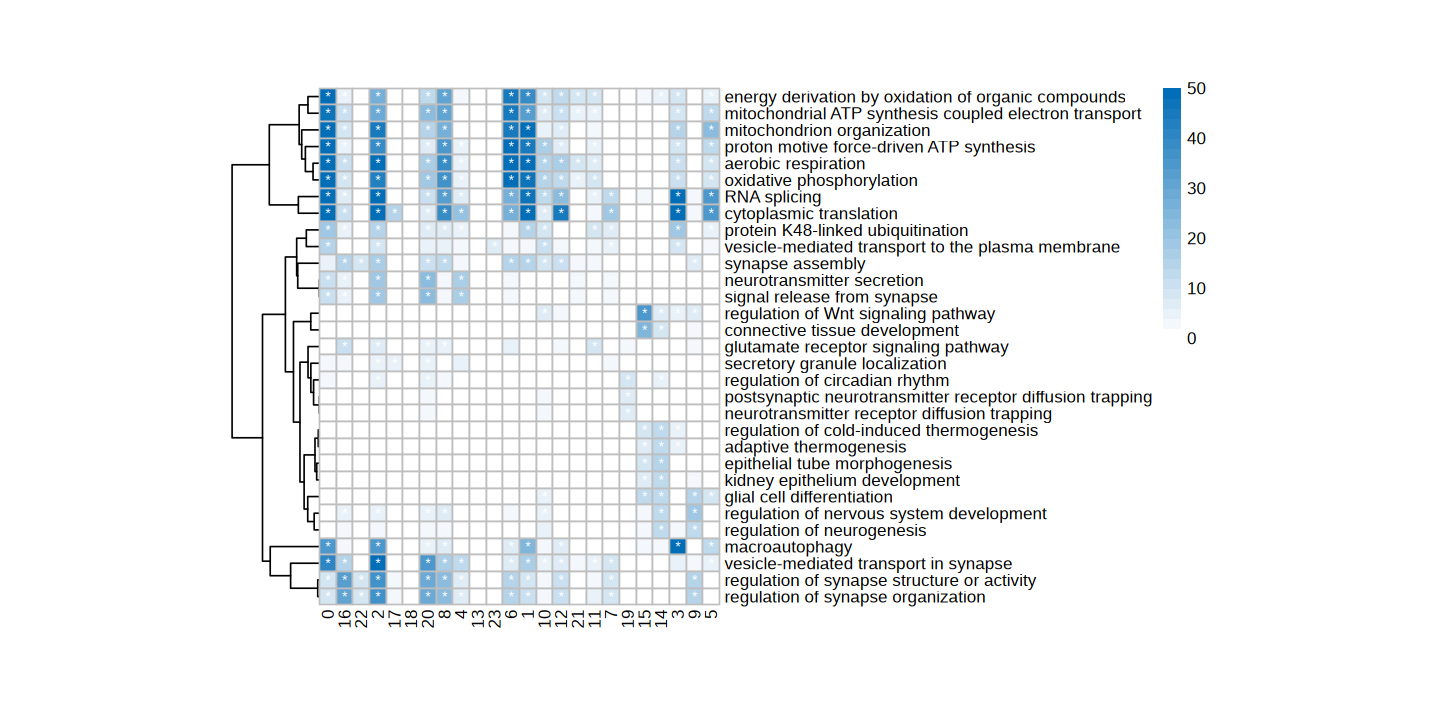

In [805]:
options(repr.plot.width = 12, repr.plot.height = 6)
ttp1[, clevel] %>% 
pheatmap(cluster_cols = F, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = lmat1[rownames(ttp1), clevel], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(25))

## Cell types oriented analysis: GO and motifs

In [591]:
for (f in unique(abcif3$celltype)){
    tmp <- abcif3 %>% filter(celltype == f) %>% dplyr::select(chr, start ,end) %>% distinct
    write.table(tmp, paste0("abc_motif/broad_abc_filter.", f, ".bed"), sep = "\t", quote = F, row.names = F, col.names = F)
}

In [14]:
mclass <- read.table("/projects//ps-renlab2/y2xie/projects/genome_ref/241102_JASPAR2022/240722_WE_JASPAR_2022_monaLisa_Dump_noPseudo_thresh0.7_annotated.txt", header = T)

In [121]:
motif <- list()
for (f in list.files("abc_motif/", pattern = "broad_abc_filter.*.bed")){
    fname <- gsub("broad_abc_filter.([^.]+).bed", "\\1", f)
    tmp <- read.csv(paste0("abc_motif/broad_abc_filter.", fname, "/knownResults.txt"), sep = "\t", row.names = 1) %>%
    setNames(c("consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
    tibble::rownames_to_column("motif") %>% mutate(celltype = fname)
    tmp$mclass <- mclass[match(tmp$motif, mclass$JASPER),]$Cluster_name
    
    motif[[f]] <- tmp
}

### Plot strongest motifs first
lmotif1 <- do.call(rbind, motif) %>%
filter(fdr < 0.01) %>%
group_by(celltype, mclass) %>% 
slice_max(order_by = -log_p_value, n = 1) %>%
slice_sample(n = 1) %>%
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
lmotif1 <- lmotif1[!is.na(lmotif1)]

rmat1 <- do.call(rbind, motif) %>%
reshape2::dcast(celltype ~ motif, value.var = "fdr", fun.aggregate = min) %>%
tibble::column_to_rownames("celltype")
rmat1[is.na(rmat1)] <- 1
rmat1 <- -log10(rmat1)
rmat1[rmat1 > 6] <- 6

smat1 <- rmat1[intersect(colnames(qmtx), rownames(rmat1)), lmotif1] %>% t
max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]

### Label the strongest in each module
lmotif2 <- do.call(rbind, motif) %>%
filter(motif %in% lmotif1) %>%
group_by(celltype) %>% 
slice_max(order_by = -log_p_value, n = 2) %>%
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
llabel <- rownames(smat1)
llabel[!(llabel %in% lmotif2)] <- ""

Warning message in .fun(.value[0], ...):
“no non-missing arguments to min; returning Inf”


In [123]:
length(lmotif1)

[1] 191

Warning message in .fun(.value[0], ...):
“no non-missing arguments to min; returning Inf”


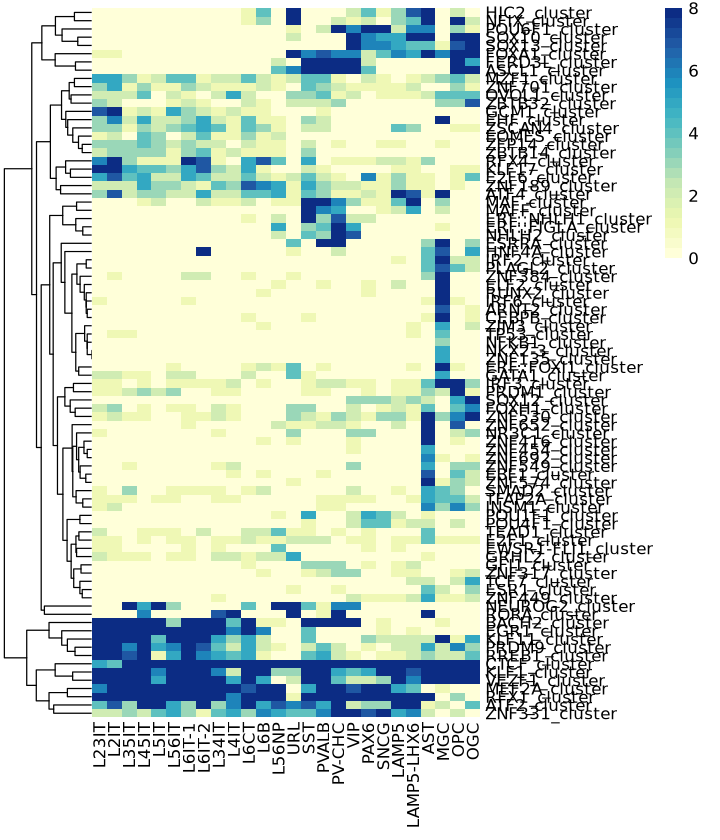

In [130]:
### Plot strongest motifs with class representation
lmotif1 <- do.call(rbind, motif) %>%
filter(fdr < 0.001) %>%
group_by(celltype, mclass) %>% 
slice_max(order_by = -log_p_value, n = 1) %>%
slice_sample(n = 1) %>%
ungroup() %>%
dplyr::select(mclass) %>% unlist %>% unique
lmotif1 <- lmotif1[!is.na(lmotif1)]

rmat1 <- do.call(rbind, motif) %>%
reshape2::dcast(celltype ~ mclass, value.var = "p_value", fun.aggregate = min) %>%
tibble::column_to_rownames("celltype")
rmat1[is.na(rmat1)] <- 1
rmat1 <- -log10(rmat1)
rmat1[rmat1 > 8] <- 8

smat2 <- rmat1[intersect(colnames(qmtx), rownames(rmat1)), lmotif1] %>% t
max_indices <- max.col(smat2)
permutation_vector <- order(max_indices)
smat2 <- smat2[permutation_vector, ]

options(repr.plot.width = 6, repr.plot.height = 7)
smat2 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, # gaps_row = nrow(smat2), 
         border_color = NA, show_colnames = T, 
         angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

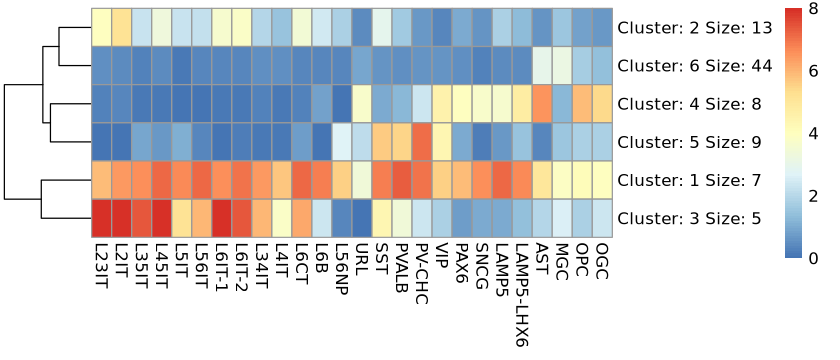

In [131]:
kn <- 6
set.seed(921)

options(repr.plot.width = 7, repr.plot.height = 3)
d1 <- smat2 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

qorder <- d1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>%
mutate(kmeansk = factor(kmeansk, levels = c(3,1,5,4,2,6))) %>%
arrange(kmeansk)

In [713]:
### Example per cluster
lmotif2 <- c("KLF1_cluster", "MEF2A_cluster", "ERG1_cluster", "PRDM9_cluster",
             "NHLH2_cluster", "MAF_cluster", "POU6F1_cluster", "FOXA1_cluster",
             "EOMES_cluster", "ZNF652_cluster", "ZBTB32_cluster", "IRF3_cluster", "RUNX2_cluster")
llabel <- rownames(smat2)
llabel[!(llabel %in% lmotif2)] <- ""

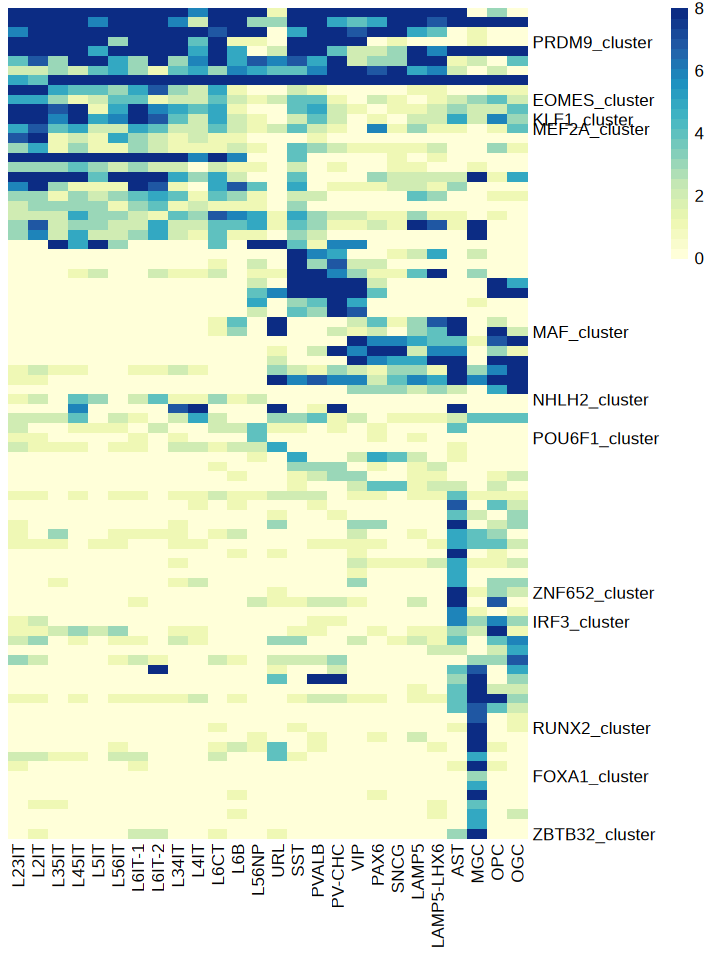

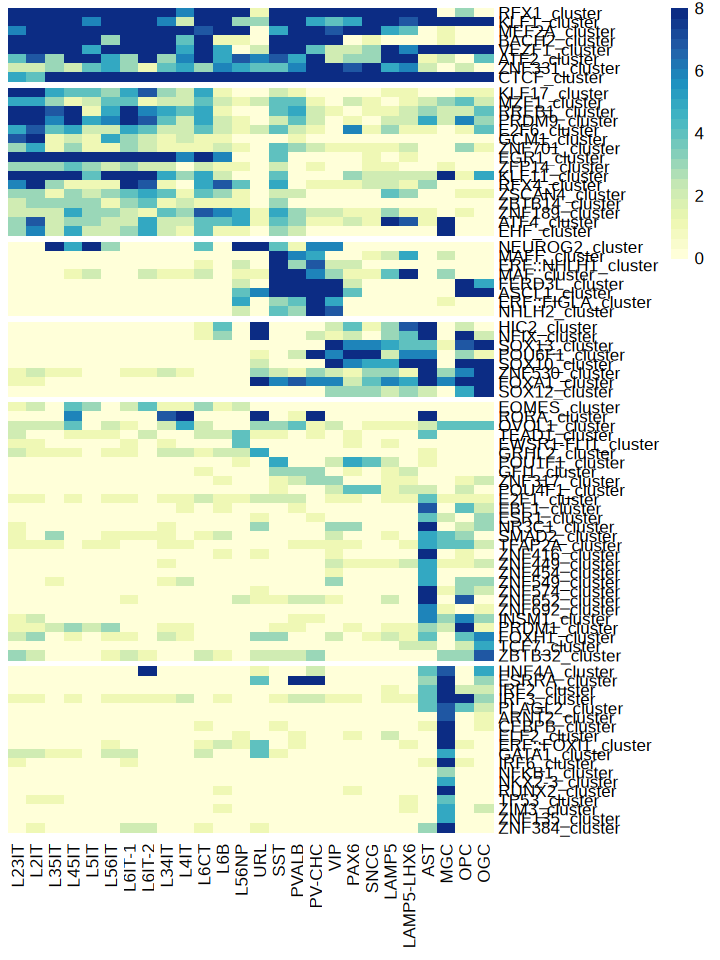

In [715]:
options(repr.plot.width = 6, repr.plot.height = 8)
fig1 <- smat2[rownames(qorder),] %>% 
pheatmap(cluster_cols = F, cluster_rows = F, #gaps_row = cumsum(table(qorder$kmeansk)), 
         border_color = NA, show_colnames = T, 
         labels_row = llabel, angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

fig2 <- smat2[rownames(qorder),] %>% 
pheatmap(cluster_cols = F, cluster_rows = F, gaps_row = cumsum(table(qorder$kmeansk)), 
         border_color = NA, show_colnames = T,  angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

In [592]:
### Gene ontology
### Only test expressed genes since abc output all...
flist <- flist2 <- list()
for (f in unique(abcif3$CellType)){ 
    qgene <- abcif3 %>% filter(CellType == f) %>% filter(TargetGeneIsExpressed == 'True') %>%
    dplyr::select(TargetGene) %>% unlist %>% unique %>% as.character
    print(length(qgene))
    qtable <- enrichGO(gene = qgene,
                OrgDb = org.Hs.eg.db,
                keyType = 'SYMBOL',
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)
    flist[[paste0(f)]] <- qtable@result %>% mutate(celltype = f) # %>% filter(p.adjust < 0.05)

    ### filter out similar GO terms
    qtable2 <- clusterProfiler::simplify(qtable, cutoff=0.7, by="p.adjust", select_fun=min)
    flist2[[paste0(f)]] <- qtable2@result %>% mutate(celltype = f) 
}

do.call(rbind, flist2) %>%
dplyr::select(celltype) %>% table

[1] 2633
[1] 2241
[1] 2372
[1] 2283
[1] 2290
[1] 2560
[1] 2004
[1] 2230
[1] 2193
[1] 2198
[1] 1954
[1] 1981
[1] 2122
[1] 2135
[1] 2180
[1] 2035
[1] 3463
[1] 2800
[1] 2428
[1] 1726
[1] 2149
[1] 2318
[1] 1763
[1] 2204
[1] 2824
[1] 2289


celltype
       AST      L23IT       L2IT      L34IT      L35IT      L45IT       L4IT 
       225        200        209        185        173        185        191 
     L56IT      L56NP       L5IT        L6B       L6CT     L6IT-1     L6IT-2 
       192        149        174        169        174        193        152 
     LAMP5 LAMP5-LHX6        MGC        OGC        OPC       PAX6     PV-CHC 
       150        140        347        177        194         70        126 
     PVALB       SNCG        SST        URL        VIP 
       149         85        168        165        149 

In [645]:
### filter terms appear in 60% cell types
qterm1 <- do.call(rbind, flist2) %>%
filter(p.adjust < 0.05, Count >= 5) %>%
group_by(Description) %>%
mutate(ncount = n_distinct(celltype)) %>% 
filter(ncount <= floor(0.7*length(unique(abcif3$celltype)))) %>%
ungroup %>% group_by(celltype) %>%
slice_max(order_by = -log10(p.adjust)*FoldEnrichment, n = 3) %>%
ungroup %>% dplyr::select(Description) %>% unlist %>% unique

length(qterm1)

qterm2 <- c('inhibitory synapse assembly', 'excitatory synapse assembly', 
'synapse pruning', 'immunological synapse formation',
'neuronal ion channel clustering', 'cerebral cortex neuron differentiation', 
'cerebral cortex GABAergic interneuron differentiation')
qterm3 <- unique(c(qterm1, qterm2))
length(qterm3)

tmp <- read.csv(paste0("abc_go/H3K27ac_wubin_filt_celltype_enrichGO.xls"), sep = "\t") %>%
reshape2::dcast(Description ~ celltype, value.var = "p.adjust", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1

ttp1 <- -log2(tmp[qterm1, intersect(corder, colnames(tmp))])
ttp1[ttp1 > 20] <- 20

lmat1 <- tmp
lmat1 <- ifelse(lmat1 < 0.01, "*", "")

[1] 46

[1] 53

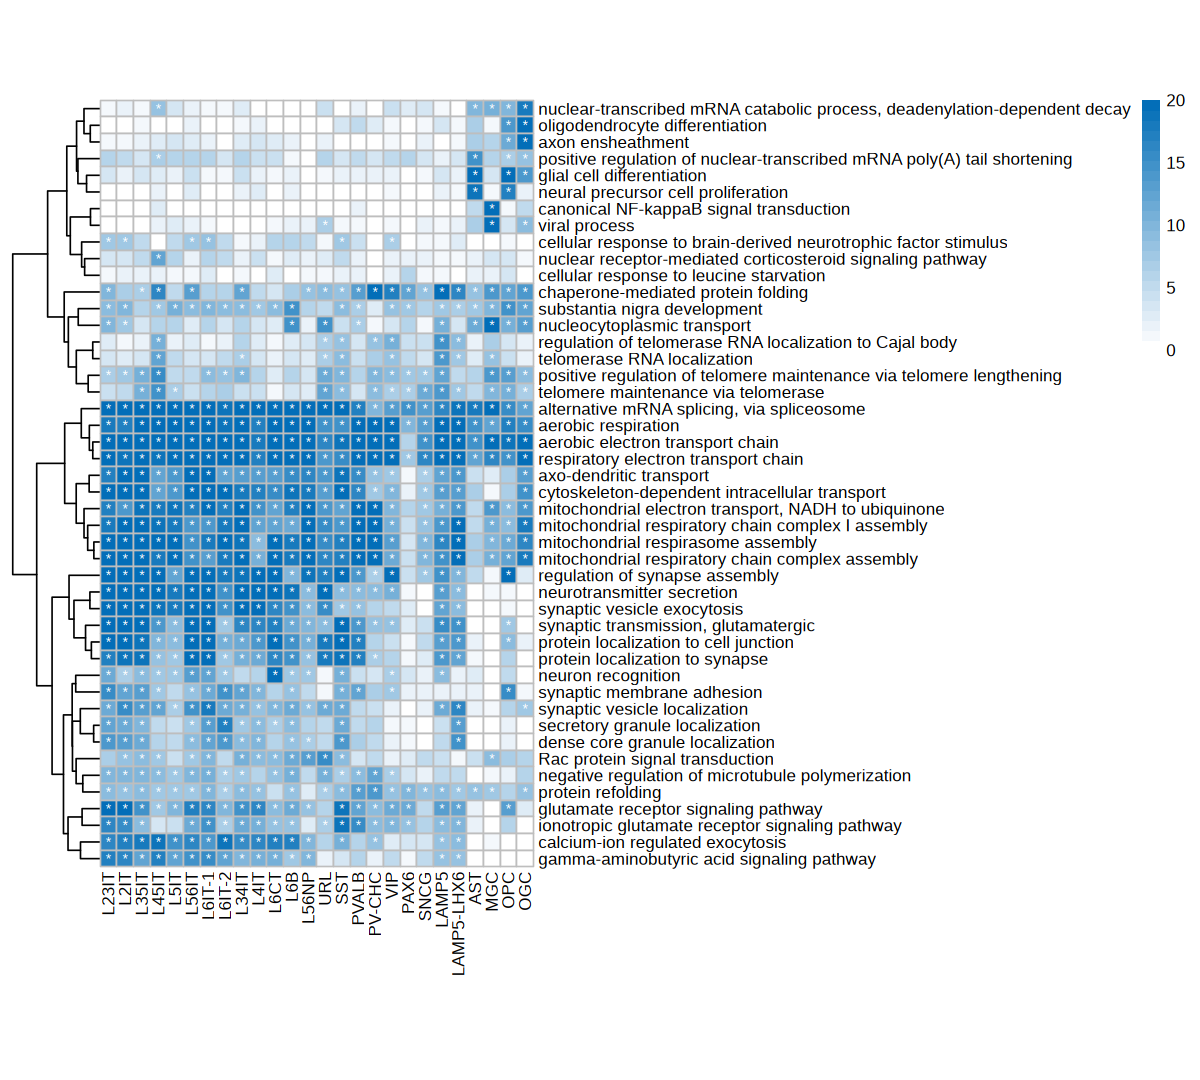

In [648]:
options(repr.plot.width = 10, repr.plot.height = 9)
qcol <- intersect(colnames(qmtx), colnames(ttp1))
fig1 <- ttp1[, qcol] %>% 
pheatmap(cluster_cols = F, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = lmat1[rownames(ttp1), qcol], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(25))

## Compare ABC links with eQTLs

In [244]:
## Prepare eQTL bed file
### SingleBrain

suppressPackageStartupMessages(library(AnnotationHub))
suppressPackageStartupMessages(library(ensembldb))

ah <- AnnotationHub()
eds <- query(ah, c("Homo sapiens","EnsDb","GRCh38"))
db  <- eds[[1]]  # choose the latest entry shown by 'eds'

### Process and retain top assoc into bedpe
for (f in list.files("../../ref/Jang2025_SingleBrain/", pattern = '.*.top_assoc.tsv.gz')){
    fname <- gsub(".tsv.gz", "", f)
    tmp <- data.table::fread(paste0("../../ref/Jang2025_SingleBrain/", f)) %>% dplyr::filter(qval < 0.05)
    tmp$gene_id <- sub("\\.\\d+$", "", tmp$feature)
    gr <- genes(db, filter = GeneIdFilter(tmp$gene_id))
    gcood <- as.data.frame(gr)[, c("seqnames","start","end","strand","gene_id","gene_name","gene_biotype")] %>%
    mutate(seqnames = paste0("chr", seqnames)) %>%
    mutate(tss = ifelse(strand == "+", start, end)) 
    
    tbed <- merge(tmp, gcood, by = "gene_id") %>%
    mutate(pos2 = pos + 1, tss2 = tss + 1) %>%
    dplyr::select(chr, pos, pos2, seqnames, tss, tss2, variant_id, gene_id, gene_name)
    write.table(tbed, paste0("../../ref/Jang2025_SingleBrain/", fname, ".top_assoc.bedpe"), 
                row.names = F, col.names = F, sep = "\t", quote = F)
}

qlist <- list()
for (f in list.files("../../ref/Jang2025_SingleBrain/", pattern = '.*_eqtl_top_assoc.top_assoc.bedpe')){
    fname <- gsub("_eqtl_top_assoc.top_assoc.bedpe", "", f)
    qlist[[fname]] <- read.table(paste0("../../ref/Jang2025_SingleBrain/", f)) 
}
qtl4 <- do.call(rbind, qlist)
tmp4 <- qtl4 %>% dplyr::select(V1, V2, V3) %>% distinct

In [654]:
### use fisher
library(BiocParallel)
register(MulticoreParam(workers = 16))

run_one <- function(f, eqtl, perm_n = 100) {
  fname <- sub("\\.bed$", "", basename(f))
  tmp   <- read.table(f, stringsAsFactors = FALSE)
  trange <- GRanges(seqnames = tmp[[1]],
                    ranges   = IRanges(as.numeric(tmp[[2]]), as.numeric(tmp[[3]])))
  n_enh <- length(trange)

  # Observed overlaps: enhancers ∩ eQTL
  a_obs <- sum(countOverlaps(trange, eqtl) > 0)
  b_obs <- n_enh - a_obs

  # Permutations: shuffle eQTLs (preserve sizes/chr distribution)
  perm_overlaps <- vapply(seq_len(perm_n), function(i) {
    eqtl_shuf <- circularRandomizeRegions(eqtl, genome = "hg38") # or resampleRegions
    sum(countOverlaps(trange, eqtl_shuf) > 0)
  }, integer(1))

  # Build Fisher tables and compute p + OR per permutation
  # Table per perm: [ [a_obs, a_perm], [b_obs, n_enh - a_perm] ]
  # i.e., rows: (observed enhancers) vs (randomized background), cols: overlap / no-overlap
  out <- data.frame(
    file   = fname,
    a_obs  = a_obs,
    a_perm = perm_overlaps,
    b_obs  = b_obs,
    b_perm = n_enh - perm_overlaps
  )
  out$pvalue <- NA_real_
  out$or     <- NA_real_

  for (i in seq_len(nrow(out))) {
    tab <- matrix(c(out$a_obs[i], out$a_perm[i],
                    out$b_obs[i], out$b_perm[i]), ncol = 2, byrow = TRUE)
    ft <- fisher.test(tab)
    out$pvalue[i] <- ft$p.value
    out$or[i]     <- unname(ft$estimate)
  }
  out
}

### eQTL from SingleBrain
qrange <- GRanges(tmp4[,1], ranges = IRanges(as.numeric(tmp4[,2]), as.numeric(tmp4[,3])))

### compare different groups of enhancers
files <- list.files("abc_candidate_enhancer/", pattern="\\.bed$", full.names=TRUE)
res_list <- bplapply(files, run_one, eqtl = qrange, perm_n = 100)
odtable <- do.call(rbind, res_list)
odtable$padj <- p.adjust(odtable$pvalue, method = "BH")

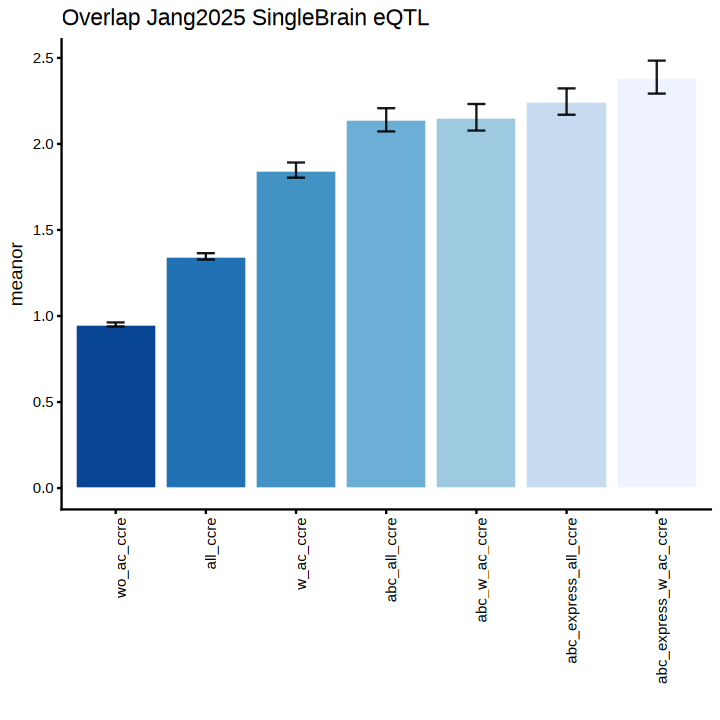

In [655]:
t1 <- odtable %>% filter(padj < 0.05) %>%
group_by(file) %>%
summarise(meanor = mean(or), sdor = sd(or)) %>%
ungroup %>%
mutate(file = factor(file, levels = c("wo_ac_ccre", "all_ccre", "w_ac_ccre", "abc_all_ccre", 
                                      "abc_w_ac_ccre", "abc_express_all_ccre", "abc_express_w_ac_ccre"))) %>%
ggplot(aes(x = file, y = meanor, fill = file)) + 
geom_col(color = "white") + xlab("") + 
geom_errorbar(aes(x=file, ymin=meanor - sdor, ymax=meanor + sdor), width=0.2, alpha=0.9) + 
theme_classic() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
scale_fill_brewer(direction = -1) + 
NoLegend() + ggtitle("Overlap Jang2025 SingleBrain eQTL")

options(repr.plot.width = 6, repr.plot.height = 6)
t1

## Compare overlap between eQTLs and ABC links

In [216]:
abcif %>% 
dplyr::select(chr, start, end) %>% distinct %>% nrow
qen <- abcif3 %>% dplyr::select(chr, start, end) %>% distinct
nrow(qen)

erange <- GRanges(qen[,1], ranges = IRanges(as.integer(qen[,2]), as.integer(qen[,3])))

[1] 122409

[1] 79593

In [217]:
qenpair <- abcif %>% dplyr::select(chr, start, end, TargetGeneTSS) %>% distinct 
prange1 <- GRanges(qenpair[,1], ranges = IRanges(as.integer(qenpair[,2]), as.integer(qenpair[,3]))) ### ccre: 500bp
prange2 <- GRanges(qenpair[,1], ranges = IRanges(as.integer(qenpair[,4]) - 250, as.integer(qenpair[,4]) + 250)) ### tss: extend 500bp
pi <- GInteractions(prange1, prange2)

In [222]:
### record both summary and type
esumm <- elink <- list()

###  Wang 2018

In [218]:
qtl <- read.table("../../ref/Wang2018Science_PsyENCODE/DER-08a_hg38_eQTL.significant.txt", header = T)
qdf <- qtl %>% dplyr::select(SNP_chr, SNP_start, SNP_end) %>% distinct
lrange1 <- GRanges(qdf$SNP_chr, ranges = IRanges(as.integer(qdf$SNP_start), as.integer(qdf$SNP_end)))

nrow(qdf)
queryHits(findOverlaps(lrange1, erange)) %>% unique %>% length ### 25563 / 1340809
subjectHits(findOverlaps(lrange1, erange)) %>% unique %>% length ### 18018 / 84315

[1] 1340809

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr7_KI270803v1_alt, chr22_KI270928v1_alt, chr22_KI270879v1_alt, chr17_KI270857v1_alt, chr8_KI270821v1_alt, chr15_KI270850v1_alt
  - in 'y': chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


[1] 24363

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr7_KI270803v1_alt, chr22_KI270928v1_alt, chr22_KI270879v1_alt, chr17_KI270857v1_alt, chr8_KI270821v1_alt, chr15_KI270850v1_alt
  - in 'y': chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


[1] 17130

In [219]:
qrange <- qdf[unique(queryHits(findOverlaps(lrange1, erange))),] 
qrange <- paste0(qrange$SNP_chr, ":", as.character(qrange$SNP_start))

qdf1 <- qtl %>% 
filter(paste0(SNP_chr, ":", SNP_start) %in% qrange) %>%
dplyr::select(SNP_chr, SNP_start, gene_chr, gene_start) %>% distinct
nrow(qdf1) ### how many eQTL to gene pair?

lrange1 <- GRanges(qdf1[,1], ranges = IRanges(as.integer(qdf1[,2]), as.integer(qdf1[,2])+1))
lrange2 <- GRanges(qdf1[,1], ranges = IRanges(as.integer(qdf1[,4]), as.integer(qdf1[,4])+1))
gi <- GInteractions(lrange1, lrange2)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr7_KI270803v1_alt, chr22_KI270928v1_alt, chr22_KI270879v1_alt, chr17_KI270857v1_alt, chr8_KI270821v1_alt, chr15_KI270850v1_alt
  - in 'y': chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


[1] 46283

In [220]:
qov <- queryHits(findOverlaps(gi, pi, type = "any", use.region="both")) %>% unique ### 20.5% eQTL-gene links can be validated
sov <- subjectHits(findOverlaps(gi, pi, type = "any", use.region="both")) %>% unique
length(sov); length(qov)

[1] 9055

[1] 11812

In [223]:
esumm[["Wang2018"]] <- data.frame(dataset = "Wang2018", total_eqtl = 1340809, ovlp_eqtl = 24363, ovlp_link = 11694, non_ovlp_link = 46283 - 11694)

In [224]:
elink[["Wang2018"]] <- do.call(rbind, list(qtl %>% 
filter(!(paste0(SNP_chr, ":", SNP_start) %in% qrange)) %>%
dplyr::select(SNP_chr, SNP_start, gene_chr, gene_start) %>% 
distinct %>% 
mutate(group = "peak_unmatched", dataset = "Wang2018"),
qdf1[qov,] %>% mutate(group = "link_matched", dataset = "Wang2018"),
qdf1[-qov,] %>% mutate(group = "link_unmatched", dataset = "Wang2018")))

### de Klein 2023 

In [225]:
qtl <- read.csv("../../ref/Klein2023NG/Klein_2023NG_cisQTL_Cortex_EUR.csv", skip = 1)
qtl <- qtl %>% dplyr::select(SNPChr, SNPPos, SNP, Gene, GeneChr, GenePos) %>%
mutate(SNPChr = paste0("chr", SNPChr))%>%
mutate(GeneChr = paste0("chr", GeneChr))

In [226]:
qdf <- qtl %>% dplyr::select(SNPChr, SNPPos) %>% distinct
lrange1 <- GRanges(qdf$SNPChr, ranges = IRanges(as.integer(qdf$SNPPos), as.integer(qdf$SNPPos)+1))
idx <- queryHits(findOverlaps(lrange1, erange)) %>% unique

In [227]:
qrange <- qdf[idx,] 
qrange <- paste0(qrange$SNPChr, ":", as.character(qrange$SNPPos))

qdf1 <- qtl %>% 
filter(paste0(SNPChr, ":", SNPPos) %in% qrange) %>%
dplyr::select(SNPChr, SNPPos, GeneChr, GenePos) %>% distinct

lrange1 <- GRanges(qdf1[,1], ranges = IRanges(as.integer(qdf1[,2]), as.integer(qdf1[,2])+1))
lrange2 <- GRanges(qdf1[,3], ranges = IRanges(as.integer(qdf1[,4]), as.integer(qdf1[,4])+1))
gi <- GInteractions(lrange1, lrange2)

In [228]:
qov <- queryHits(findOverlaps(gi, pi, type = "any", use.region="both")) %>% unique ### 42.8% eQTL-gene links can be validated
esumm[["deKlein2023"]] <- data.frame(dataset = "de Klein 2023", total_eqtl = nrow(qdf), ovlp_eqtl = length(idx), ovlp_link = length(qov), non_ovlp_link = nrow(qdf1) - length(qov))

In [229]:
elink[["deKlein2023"]] <- do.call(rbind, list(qtl %>% 
filter(!(paste0(SNPChr, ":", SNPPos) %in% qrange)) %>%
dplyr::select(SNPChr, SNPPos, GeneChr, GenePos) %>% distinct %>% 
mutate(group = "peak_unmatched", dataset = "deKlein2023"),
qdf1[qov,] %>% mutate(group = "link_matched", dataset = "deKlein2023"),
qdf1[-qov,] %>% mutate(group = "link_unmatched", dataset = "deKlein2023")))

### Bryois 2022 

In [230]:
qtl <- read.csv("../../ref/Bryois2022NG/Bryois2022NG_cts_cis_eQTL.csv", skip = 3) %>% filter(adj_p < 0.05)
snp_id <- read.table("../../../genome_ref/Bryois2022_NatNeu_human_brain_eQTL/snp_pos.txt", header = T)
qtl <- merge(qtl, snp_id, by = "SNP") %>%
mutate(gpos = pos_hg38 - dist_TSS) %>%
dplyr::select(chr, pos_hg38, SNP, gpos, cell_type, symbol) %>%
filter(!is.na(chr))

In [231]:
qdf <- qtl %>% dplyr::select(chr, pos_hg38) %>% distinct
lrange1 <- GRanges(qdf$chr, ranges = IRanges(as.integer(qdf$pos_hg38), as.integer(qdf$pos_hg38)+1))
idx <- queryHits(findOverlaps(lrange1, erange)) %>% unique 

In [232]:
qrange <- qdf[idx,] 
qrange <- paste0(qrange$chr, ":", as.character(qrange$pos_hg38))

qdf1 <- qtl %>% 
filter(paste0(chr, ":", pos_hg38) %in% qrange) %>%
dplyr::select(chr, pos_hg38, gpos) %>% distinct

lrange1 <- GRanges(qdf1[,1], ranges = IRanges(as.integer(qdf1[,2]), as.integer(qdf1[,2])+1))
lrange2 <- GRanges(qdf1[,1], ranges = IRanges(as.integer(qdf1[,3]), as.integer(qdf1[,3])+1))
gi <- GInteractions(lrange1, lrange2)
qov <- queryHits(findOverlaps(gi, pi, type = "any", use.region="both")) %>% unique

esumm[["Bryois2022"]] <- data.frame(dataset = "Bryois2022", total_eqtl = nrow(qdf), ovlp_eqtl = length(idx), ovlp_link = length(qov), non_ovlp_link = nrow(qdf1) - length(qov))

In [233]:
elink[["Bryois2022"]] <- do.call(rbind, list(qtl %>% 
filter(!(paste0(chr, ":", pos_hg38) %in% qrange)) %>%
dplyr::select(chr, pos_hg38, gpos) %>% distinct %>% 
mutate(group = "peak_unmatched", dataset = "Bryois2022"),
qdf1[qov,] %>% mutate(group = "link_matched", dataset = "Bryois2022"),
qdf1[-qov,] %>% mutate(group = "link_unmatched", dataset = "Bryois2022")))

### Jang 2025 (SingleBrain)

In [234]:
qlist <- list()
for (f in list.files("../../ref/Jang2025_SingleBrain/", pattern = '.*_eqtl_top_assoc.top_assoc.bedpe')){
    fname <- gsub("_eqtl_top_assoc.top_assoc.bedpe", "", f)
    qlist[[fname]] <- read.table(paste0("../../ref/Jang2025_SingleBrain/", f)) # %>% select(V1, V2, V3)  
}
qtl4 <- do.call(rbind, qlist)

qdf <- qtl4 %>% dplyr::select(V1, V2) %>% distinct
lrange1 <- GRanges(qdf[,1], ranges = IRanges(as.integer(qdf[,2]), as.integer(qdf[,2])+1))
idx <- queryHits(findOverlaps(lrange1, erange)) %>% unique 

qrange <- qdf[idx,] 
qrange <- paste0(qrange$V1, ":", as.character(qrange$V2))

qdf1 <- qtl4 %>% 
filter(paste0(V1, ":", V2) %in% qrange) %>%
dplyr::select(V1, V2, V4, V5) %>% distinct

lrange1 <- GRanges(qdf1[,1], ranges = IRanges(as.integer(qdf1[,2]), as.integer(qdf1[,2])+1))
lrange2 <- GRanges(qdf1[,3], ranges = IRanges(as.integer(qdf1[,4]), as.integer(qdf1[,4])+1))
gi <- GInteractions(lrange1, lrange2)
qov <- queryHits(findOverlaps(gi, pi, type = "any", use.region="both")) %>% unique

esumm[["Jang2025"]] <- data.frame(dataset = "Jang2025", total_eqtl = nrow(qdf), ovlp_eqtl = length(idx), ovlp_link = length(qov), non_ovlp_link = nrow(qdf1) - length(qov))

In [235]:
elink[["Jang2025"]] <- do.call(rbind, list(qtl4 %>% 
filter(!(paste0(V1, ":", V2) %in% qrange)) %>%
dplyr::select(V1, V2, V4, V5) %>% distinct %>% 
mutate(group = "peak_unmatched", dataset = "Jang2025"),
qdf1[qov,] %>% mutate(group = "link_matched", dataset = "Jang2025"),
qdf1[-qov,] %>% mutate(group = "link_unmatched", dataset = "Jang2025")))

### Emani 2024

In [236]:
qlist <- list()
for (f in list.files("../../ref/Emani2024Science/eQTL/", pattern = '.*_sig_QTLs.dat')){
    fname <- gsub("_sig_QTLs.dat", "", f)
    qlist[[fname]] <- read.table(paste0("../../ref/Emani2024Science/eQTL/", f)) %>% 
    setNames(c("gene_id","gene_chr","gene_start","gene_end","strand",
             "n_samples","n_tests","variant_id","snp_chr",
             "snp_start","snp_end","pval","beta_se","beta","sig_flag"))  
}

qtl5 <- do.call(rbind, qlist)

qdf <- qtl5 %>% dplyr::select(snp_chr, snp_start) %>% distinct
lrange1 <- GRanges(qdf[,1], ranges = IRanges(as.integer(qdf[,2]), as.integer(qdf[,2])+1))
idx <- queryHits(findOverlaps(lrange1, erange)) %>% unique 

qrange <- qdf[idx,] 
qrange <- paste0(qrange[,1], ":", as.character(qrange[,2]))

qdf1 <- qtl5 %>% 
filter(paste0(snp_chr, ":", snp_start) %in% qrange) %>%
dplyr::select(snp_chr, snp_start, gene_chr, gene_start) %>% distinct

lrange1 <- GRanges(qdf1[,1], ranges = IRanges(as.integer(qdf1[,2]), as.integer(qdf1[,2])+1))
lrange2 <- GRanges(qdf1[,3], ranges = IRanges(as.integer(qdf1[,4]), as.integer(qdf1[,4])+1))
gi <- GInteractions(lrange1, lrange2)
qov <- queryHits(findOverlaps(gi, pi, type = "any", use.region="both")) %>% unique

esumm[["Emani2024"]] <- data.frame(dataset = "Emani2024", total_eqtl = nrow(qdf), ovlp_eqtl = length(idx), ovlp_link = length(qov), non_ovlp_link = nrow(qdf1) - length(qov))

In [237]:
elink[["Emani2024"]] <- do.call(rbind, list(qtl5 %>% 
filter(!(paste0(snp_chr, ":", snp_start) %in% qrange)) %>%
dplyr::select(snp_chr, snp_start, gene_chr, gene_start) %>% distinct %>% 
mutate(group = "peak_unmatched", dataset = "Emani2024"),
qdf1[qov,] %>% mutate(group = "link_matched", dataset = "Emani2024"),
qdf1[-qov,] %>% mutate(group = "link_unmatched", dataset = "Emani2024")))

### Summary

Using dataset as id variables



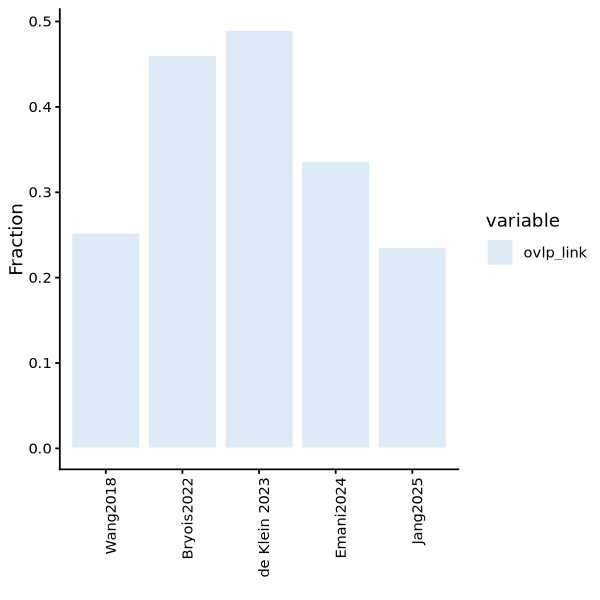

In [238]:
t1 <- do.call(rbind, esumm) %>% 
dplyr::select(dataset, ovlp_link, non_ovlp_link) %>%
reshape2::melt() %>% group_by(dataset) %>% mutate(ratio = value/sum(value)) %>%
ungroup %>% filter(variable == 'ovlp_link') %>%
mutate(dataset = factor(dataset, levels = c("Wang2018", "Bryois2022", "de Klein 2023", "Emani2024", "Jang2025"))) %>%
ggplot(aes(x = dataset, y = ratio, fill = variable)) + 
geom_col(position = "stack", color = "white") + 
theme_classic() + 
xlab("") + ylab("Fraction") + 
scale_fill_brewer() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

options(repr.plot.width = 5, repr.plot.height = 5)
t1

Using dataset as id variables



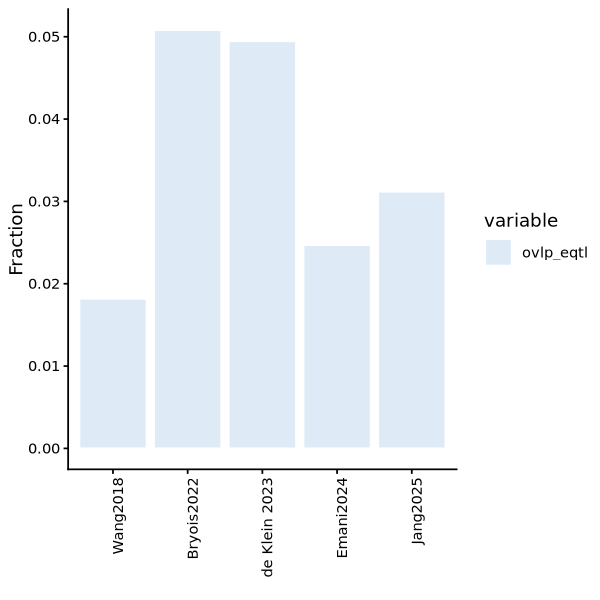

In [240]:
t1 <- do.call(rbind, esumm) %>% mutate(novlp_eqtl = total_eqtl - ovlp_eqtl) %>%
dplyr::select(dataset, novlp_eqtl, ovlp_eqtl) %>%
reshape2::melt() %>% group_by(dataset) %>% mutate(ratio = value/sum(value)) %>%
ungroup %>% filter(variable == 'ovlp_eqtl') %>%
mutate(dataset = factor(dataset, levels = c("Wang2018", "Bryois2022", "de Klein 2023", "Emani2024", "Jang2025"))) %>%
ggplot(aes(x = dataset, y = ratio, fill = variable)) + 
geom_col(position = "stack", color = "white") + 
theme_classic() + 
xlab("") + ylab("Fraction") + 
scale_fill_brewer() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1))

options(repr.plot.width = 5, repr.plot.height = 5)
t1

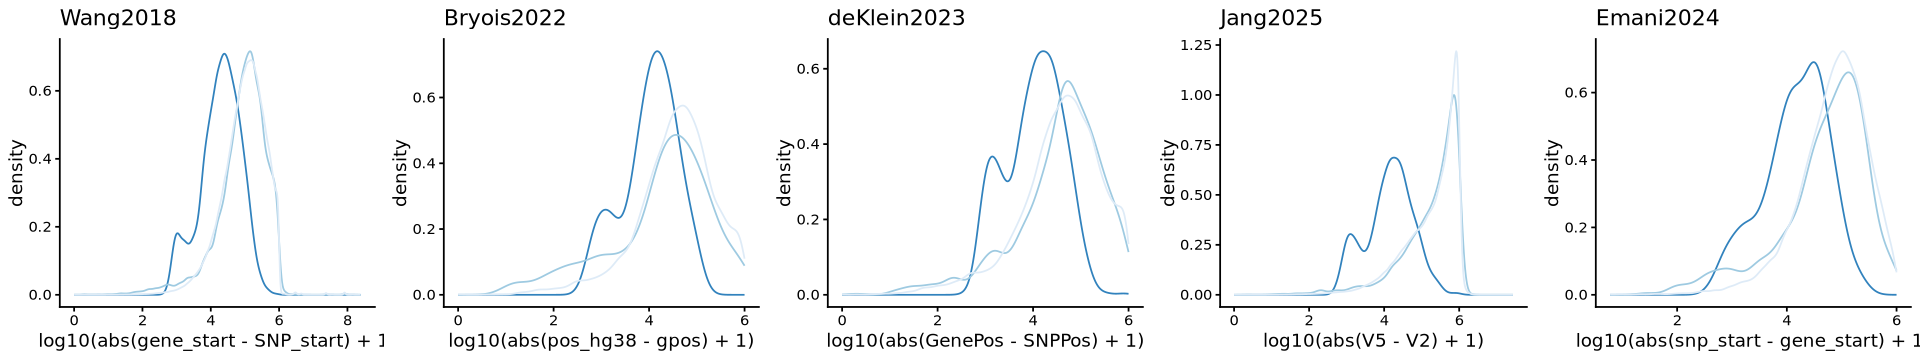

In [241]:
### Inspect difference in distance
t1 <- elink[["Wang2018"]] %>%
ggplot(aes(x = log10(abs(gene_start - SNP_start)+1), color = group)) + 
geom_density() + ggtitle("Wang2018") + 
theme_classic() + 
scale_color_brewer(direction = -1) + NoLegend()

t2 <- elink[["Bryois2022"]] %>%
ggplot(aes(x = log10(abs(pos_hg38 - gpos)+1), color = group)) + 
geom_density() + ggtitle("Bryois2022") + 
theme_classic() + 
scale_color_brewer(direction = -1) + NoLegend()

t3 <- elink[["deKlein2023"]] %>%
ggplot(aes(x = log10(abs(GenePos - SNPPos)+1), color = group)) + 
geom_density() + ggtitle("deKlein2023") + 
theme_classic() + 
scale_color_brewer(direction = -1) + NoLegend()

t4 <- elink[["Jang2025"]] %>%
ggplot(aes(x = log10(abs(V5 - V2)+1), color = group)) + 
geom_density() + ggtitle("Jang2025") + 
theme_classic() + 
scale_color_brewer(direction = -1) + NoLegend()

t5 <- elink[["Emani2024"]] %>%
ggplot(aes(x = log10(abs(snp_start - gene_start)+1), color = group)) + 
geom_density() + ggtitle("Emani2024") + 
theme_classic() + 
scale_color_brewer(direction = -1) + NoLegend()

options(repr.plot.width = 16, repr.plot.height = 3)
fig1 <- cowplot::plot_grid(t1, t2, t3, t4, t5, ncol = 5)

fig1

In [29]:
## Demostrate examples
### 1. JAM2 in LAMP5: SNP posistion chr21:25686759
### 2. KAT2B in OPC (NonN): chr3:20072552 ()
### 3. USP6NL in MGC: chr10:11678309 [chr10:11400000-11850000]
### 4: TESC in L6IT-2: chr12:117040011 [chr12:116800000-117300000]

In [41]:
tmp <- qtl %>% 
dplyr::select(chr, pos_hg38, SNP) %>%
mutate(end = pos_hg38+1) %>%
dplyr::select(chr, pos_hg38, end, SNP)

write.table(tmp, "/projects//ps-renlab2/y2xie/public_html/BICAN/MiniAtlas_subclass/H3K27ac_abc_filtcelltype_conns_ovlp_Bryois_cts_eQTL.bed", row.names = F, col.names = F, sep = "\t", quote = F)

In [25]:
f <- "L6IT-2"
tmp <- ovlist %>% filter(query == "Excitatory neurons", abc == f)
tmp

,chr,pos_hg38,gpos,query,abc
,<chr>,<int>,<int>,<chr>,<chr>
Excitatory neurons:L6IT-2.18,chr12,117040011,117099480,Excitatory neurons,L6IT-2
Excitatory neurons:L6IT-2.33,chr15,63056897,63042633,Excitatory neurons,L6IT-2
Excitatory neurons:L6IT-2.34,chr15,63277703,63276019,Excitatory neurons,L6IT-2
Excitatory neurons:L6IT-2.40,chr17,19974056,19978344,Excitatory neurons,L6IT-2
Excitatory neurons:L6IT-2.46,chr18,75203984,75209140,Excitatory neurons,L6IT-2
Excitatory neurons:L6IT-2.80,chr3,130893987,130850596,Excitatory neurons,L6IT-2
Excitatory neurons:L6IT-2.86,chr6,108850823,108848417,Excitatory neurons,L6IT-2
Excitatory neurons:L6IT-2.91,chr6,69797227,69867237,Excitatory neurons,L6IT-2
Excitatory neurons:L6IT-2.104,chr9,79589032,79571774,Excitatory neurons,L6IT-2


In [26]:
merge(qtl, tmp, by = c("chr","pos_hg38","gpos")) %>%
mutate(distance = gpos - pos_hg38)

chr,pos_hg38,gpos,SNP,cell_type,symbol,query,abc,distance
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
chr12,117040011,117099480,rs7978725,Excitatory neurons,TESC,Excitatory neurons,L6IT-2,59469
chr15,63056897,63042633,rs4775613,Excitatory neurons,TPM1,Excitatory neurons,L6IT-2,-14264
chr15,63277703,63276019,rs117618017,Excitatory neurons,APH1B,Excitatory neurons,L6IT-2,-1684
chr17,19974056,19978344,rs35925051,Excitatory neurons,AKAP10,Excitatory neurons,L6IT-2,4288
chr18,75203984,75209140,rs2639989,Excitatory neurons,ZADH2,Excitatory neurons,L6IT-2,5156
chr3,130893987,130850596,rs28362548,Excitatory neurons,ATP2C1,Excitatory neurons,L6IT-2,-43391
chr6,108850823,108848417,rs2768543,Excitatory neurons,ARMC2,Excitatory neurons,L6IT-2,-2406
chr6,69797227,69867237,rs3752789,Excitatory neurons,LMBRD1,Excitatory neurons,L6IT-2,70010
chr9,79589032,79571774,rs2791572,Excitatory neurons,TLE4,Excitatory neurons,L6IT-2,-17258



        Astrocytes  Endothelial cells Excitatory neurons Inhibitory neurons 
              3499                438              10098               2950 
         Microglia   Oligodendrocytes        OPCs / COPs          Pericytes 
              1623               6688               2120                201 

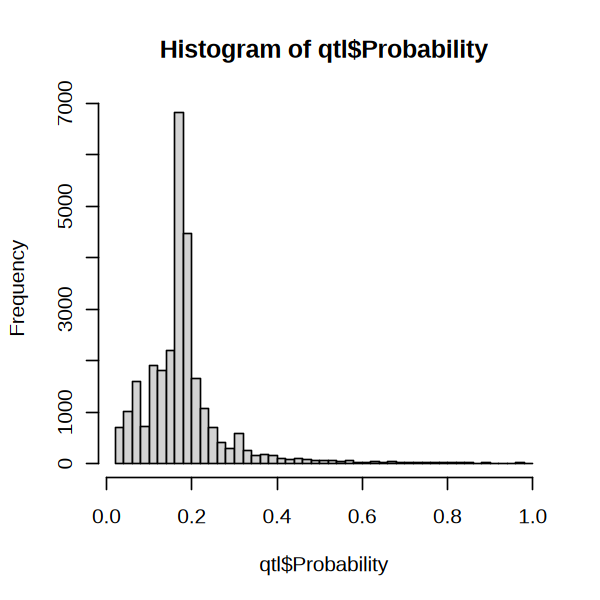

In [151]:
options(repr.plot.width = 5, repr.plot.height = 5)
qtl <- read.csv("../../ref/Bryois2022NG/Bryois_ciseQTL_fine_mapped.csv", skip = 3)
table(qtl$cell_type)
hist(qtl$Probability, breaks = 50)

In [189]:
qtl[qtl$Probability > 0.5,]$cell_type %>% table
qtl[qtl$Probability < 0.5,]$cell_type %>% table

.
        Astrocytes  Endothelial cells Excitatory neurons Inhibitory neurons 
                66                 10                198                 63 
         Microglia   Oligodendrocytes        OPCs / COPs          Pericytes 
                37                162                 54                  1 

.
        Astrocytes  Endothelial cells Excitatory neurons Inhibitory neurons 
              3433                428               9900               2887 
         Microglia   Oligodendrocytes        OPCs / COPs          Pericytes 
              1586               6526               2066                200 

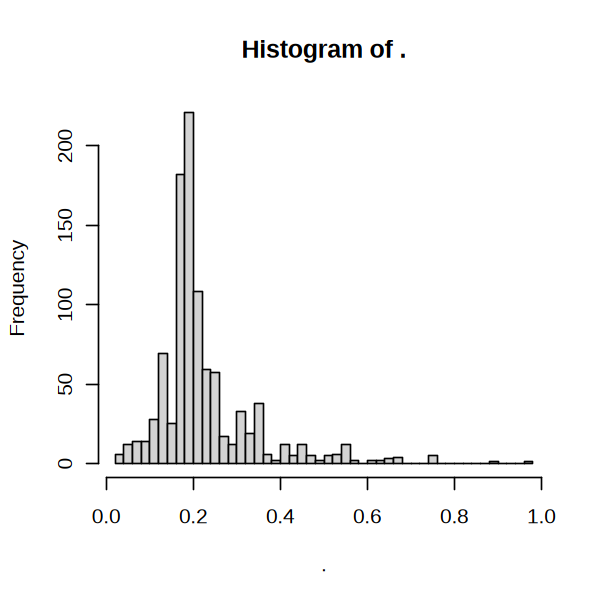

In [183]:
merge(qtl, abcif, by.x = "symbol", by.y = "TargetGene") %>%
filter(start.x < pos_hg38, end.x > pos_hg38) %>% 
dplyr::select(Probability) %>% unlist %>% hist(breaks = 50)

In [184]:
### By cell types?
tmp <- qtl[qtl$Probability > 0.8,] %>% filter(cell_type == 'Oligodendrocytes')
nrow(tmp)
tmp2 <- abcif %>% filter(CellType == "OGC")
merge(tmp, tmp2, by.x = "symbol", by.y = "TargetGene") %>%
filter(start.x < pos_hg38, end.x > pos_hg38) %>% dim

tmp <- qtl[qtl$Probability <= 0.1,] %>% filter(cell_type == 'Oligodendrocytes')
nrow(tmp)
merge(tmp, tmp2, by.x = "symbol", by.y = "TargetGene") %>%
filter(start.x < pos_hg38, end.x > pos_hg38) %>% dim

### This one doesnt work

[1] 29

[1]  0 22

[1] 764

[1]  0 22

In [194]:
abcif %>% filter(TargetGene == "PICALM") %>% dplyr::select(CellType) %>% table
abcif %>% filter(TargetGene == "GLUD1") %>% dplyr::select(CellType) %>% table

CellType
       AST        FBL      L23IT       L2IT      L34IT      L35IT      L45IT 
         4          5          1          1          1          1          1 
      L4IT      L56IT      L56NP       L5IT        L6B       L6CT     L6IT-1 
         1          1          3          1          5          1          1 
    L6IT-2      LAMP5 LAMP5-LHX6        MGC        MSN        OGC        OPC 
         1          4          2         12          2          6          2 
      PAX6     PV-CHC      PVALB       SNCG        SST        URL        VIP 
         3          1          2          2          1          1          1 

CellType
  AST   FBL L56IT L56NP  L5IT   L6B  L6CT   MGC   MSN   OGC   OPC PVALB   SST 
    7     4     2     1     5     1     3     1     3     5     4     2     3 

## Motif analysis

In [147]:
mclass <- read.table("/projects//ps-renlab2/y2xie/projects/genome_ref/241102_JASPAR2022/240722_WE_JASPAR_2022_monaLisa_Dump_noPseudo_thresh0.7_annotated.txt", header = T)

In [829]:
for (f in unique(abcif$CellType)){ 
    qgene <- abcif %>% 
    filter(CellType == f, state == "w_ac") %>%
    dplyr::select(chr, start.x, end.x) %>% distinct
    write.table(qgene, paste0("abc_motif/", f, ".abcif.bed"), sep = "\t", 
                quote = F, row.names = F, col.names = F)
}

In [148]:
motif <- list()
for (f in corder){ 
    if(file.exists(paste0("abc_motif/", f, ".abcif.bed"))){
        tmp <- read.csv(paste0("abc_motif/", f, ".abcif/knownResults.txt"), sep = "\t", row.names = 1) %>%
        setNames(c("consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
        tibble::rownames_to_column("motif") %>% mutate(celltype = paste0(f))

        tmp$mclass <- mclass[match(tmp$motif, mclass$JASPER),]$Cluster_name
        motif[[paste0(f)]] <- tmp
    }
}

In [167]:
### Plot strongest motifs first
lmotif1 <- do.call(rbind, motif) %>%
filter(fdr < 0.01) %>%
group_by(celltype, mclass) %>% 
slice_max(order_by = -log_p_value, n = 1) %>%
slice_sample(n = 1) %>%
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
lmotif1 <- lmotif1[!is.na(lmotif1)]

rmat1 <- do.call(rbind, motif) %>%
reshape2::dcast(celltype ~ motif, value.var = "fdr", fun.aggregate = min) %>%
tibble::column_to_rownames("celltype")
rmat1[is.na(rmat1)] <- 1
rmat1 <- -log10(rmat1)
rmat1[rmat1 > 6] <- 6

smat1 <- rmat1[intersect(colnames(qmtx), rownames(rmat1)), lmotif1] %>% t
max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]

Warning message in .fun(.value[0], ...):
“no non-missing arguments to min; returning Inf”


In [1305]:
### Label the strongest in each module
lmotif2 <- do.call(rbind, motif) %>%
filter(motif %in% lmotif1) %>%
group_by(celltype) %>% 
slice_max(order_by = -log_p_value, n = 2) %>%
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
llabel <- rownames(smat1)
llabel[!(llabel %in% lmotif2)] <- ""

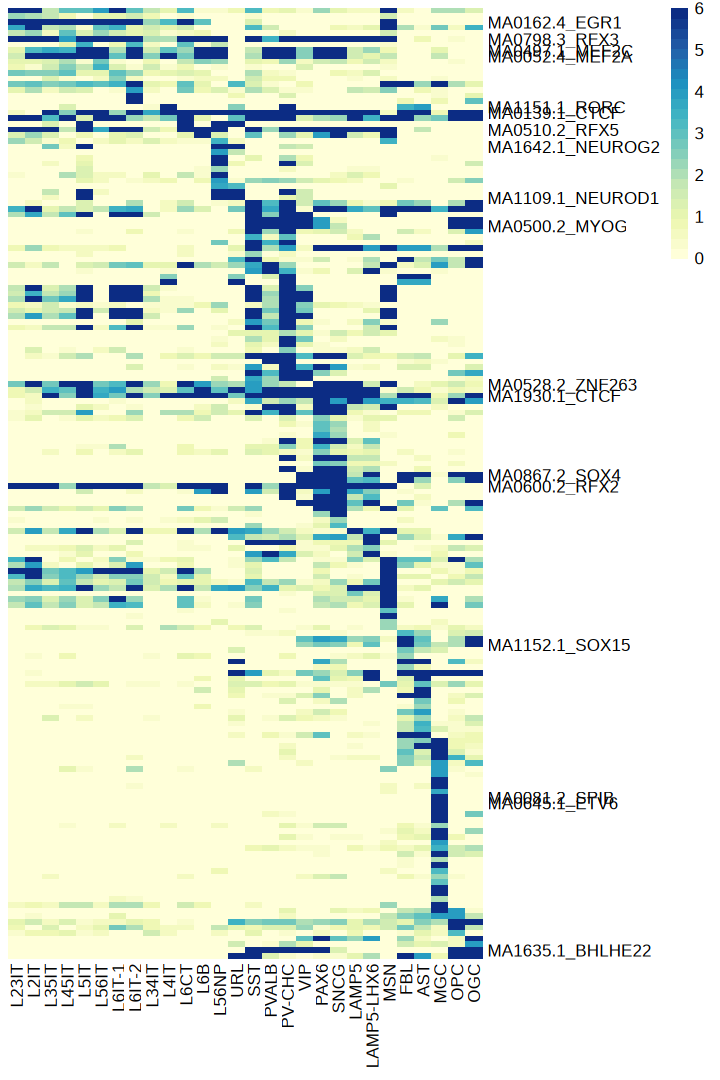

In [1306]:
options(repr.plot.width = 6, repr.plot.height = 9)
fig1 <- smat1 %>% 
pheatmap(cluster_cols = F, cluster_rows = F, # gaps_row = nrow(smat2), 
         labels_row = llabel, show_rownames = T,
         border_color = NA, show_colnames = T, 
         angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

Warning message in .fun(.value[0], ...):
“no non-missing arguments to min; returning Inf”


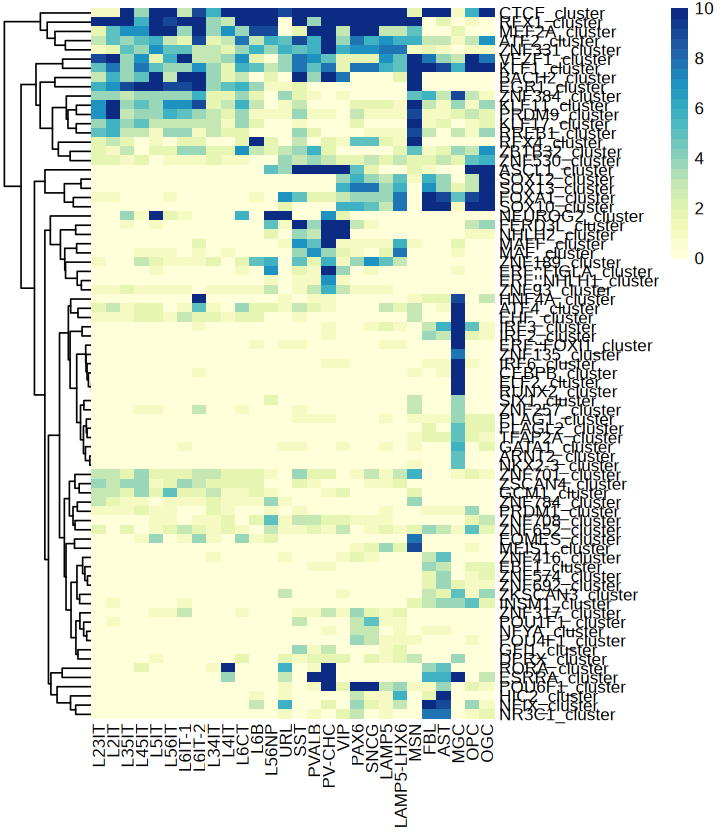

In [1436]:
### Plot strongest motifs with class representation
lmotif1 <- do.call(rbind, motif) %>%
filter(fdr < 0.001) %>%
group_by(celltype, mclass) %>% 
slice_max(order_by = -log_p_value, n = 1) %>%
slice_sample(n = 1) %>%
ungroup() %>%
dplyr::select(mclass) %>% unlist %>% unique
lmotif1 <- lmotif1[!is.na(lmotif1)]

rmat1 <- do.call(rbind, motif) %>%
reshape2::dcast(celltype ~ mclass, value.var = "p_value", fun.aggregate = min) %>%
tibble::column_to_rownames("celltype")
rmat1[is.na(rmat1)] <- 1
rmat1 <- -log10(rmat1)
rmat1[rmat1 > 10] <- 10

smat2 <- rmat1[intersect(colnames(qmtx), rownames(rmat1)), lmotif1] %>% t
max_indices <- max.col(smat2)
permutation_vector <- order(max_indices)
smat2 <- smat2[permutation_vector, ]

options(repr.plot.width = 6, repr.plot.height = 7)
smat2 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, # gaps_row = nrow(smat2), 
         border_color = NA, show_colnames = T, 
         angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

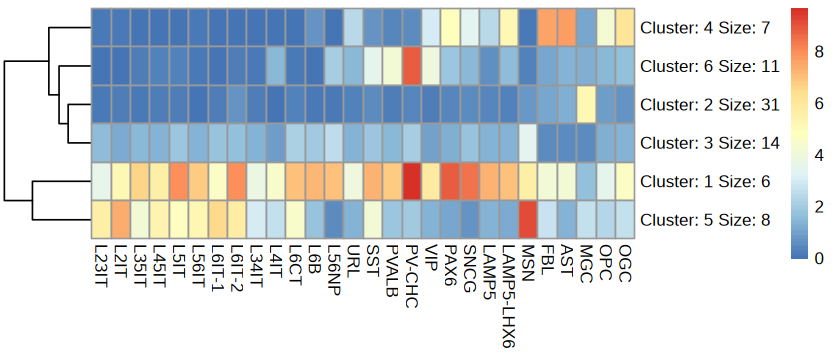

In [1439]:
kn <- 6
set.seed(921)

options(repr.plot.width = 7, repr.plot.height = 3)
d1 <- smat2 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

qorder <- d1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>% # filter(kmeansk != 7) %>%
mutate(kmeansk = factor(kmeansk, levels = c(1, 5, 3, 6, 4, 2))) %>%
arrange(kmeansk)

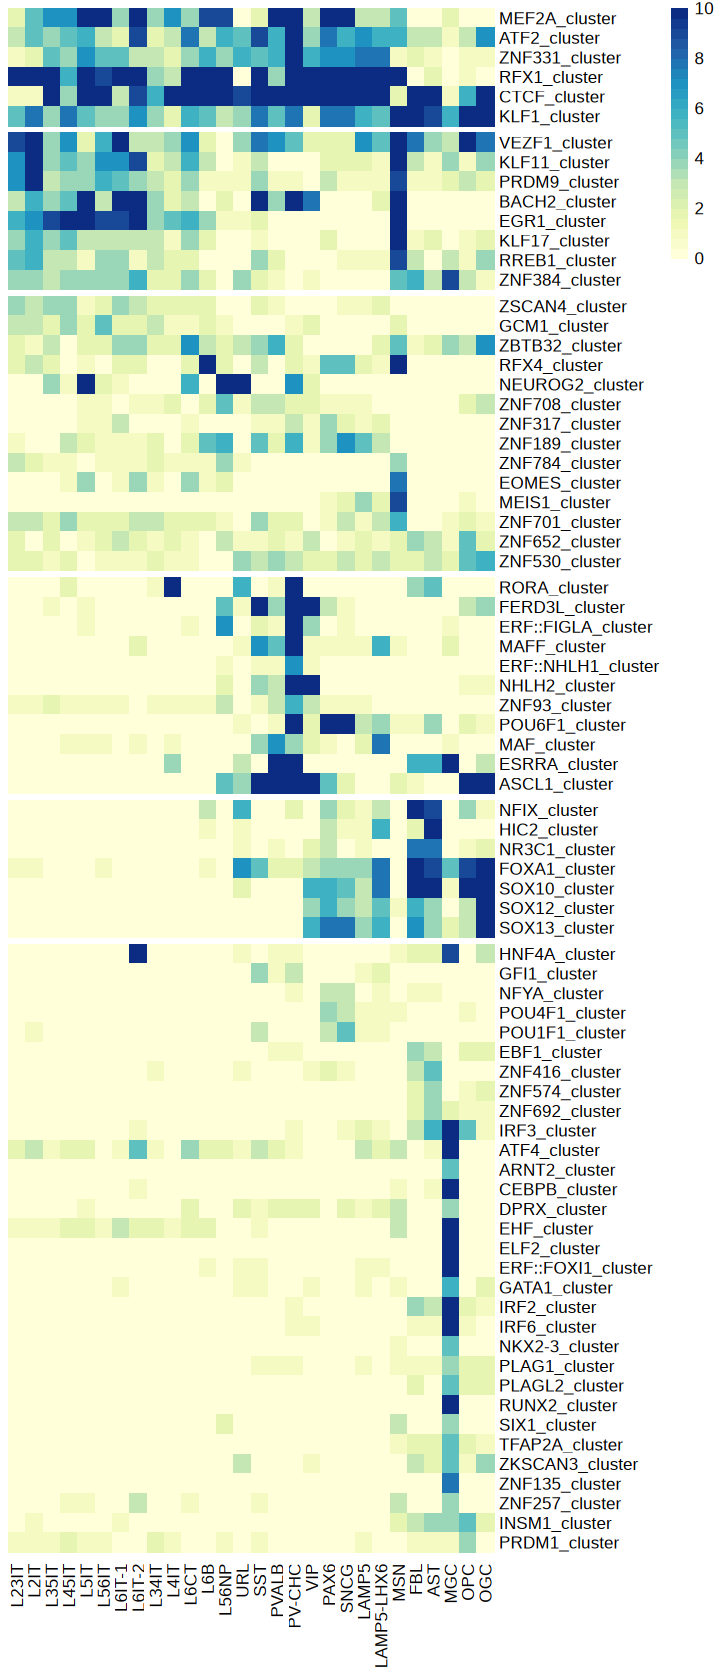

In [1440]:
options(repr.plot.width = 6, repr.plot.height = 14)
fig1 <- smat2[rownames(qorder),] %>% 
pheatmap(cluster_cols = F, cluster_rows = F, gaps_row = cumsum(table(qorder$kmeansk)), 
             border_color = NA, show_colnames = T, 
         angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

In [ ]:
### https://github.com/faryabiLab/enhancer-promoter-hub

In [ ]:
d1 <- abci[abci$state == "w_ac",]$range %>% unique %>% as.data.frame %>% 
setNames("range") %>%
mutate(range = gsub("[:-]", "_", range)) %>% mutate(label = "enhancer")
d2 <- abci[abci$state == "w_ac",]$tss %>% unique %>% as.data.frame %>% 
setNames("range") %>%
mutate(range = gsub("[:-]", "_", range)) %>% mutate(label = "promoter")
df <- rbind(d1, d2) 
write.table(df, "../08.conns/abc_hubs/abci_label.csv")

In [92]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,13667334,730.0,24609412,1314.3,20211513,1079.5
Vcells,102960552,785.6,165380030,1261.8,165332592,1261.4
